# DSAIT4335 Recommender Systems
# Final Project

In this project, you will work to build different recommendation models and evaluate the effectiveness of these models through offline experiments. The dataset used for the experiments is **MovieLens100K**, a movie recommendation dataset collected by GroupLens: https://grouplens.org/datasets/movielens/100k/. For more details, check the project description on Brightspace.

# Instruction

The MovieLens100K is already splitted into 80% training and 20% test sets. Along with training and test sets, movies metadata as content information is also provided.

**Expected file structure** for this assignment:   
   
   ```
   RecSysProject/
   ├── training.txt
   ├── test.txt
   ├── movies.txt
   └── codes.ipynb
   ```

**Note:** Be sure to run all cells in each section sequentially, so that intermediate variables and packages are properly carried over to subsequent cells.

**Note** Be sure to run all cells such that the submitted file contains the output of each cell.

**Note** Feel free to add cells if you need more for answering a question.

**Submission:** Answer all the questions in this jupyter-notebook file. Submit this jupyter-notebook file (your answers included) to Brightspace. Change the name of this jupyter-notebook file to your group number: example, group10 -> 10.ipynb.

# Setup

Import necessary libraries/packages.

In [3]:
from typing import Dict, Any

from numpy import floating
!pip install transformers torch
# For BERT

# you can refer https://huggingface.co/docs/transformers/en/model_doc/bert for various versions of the pre-trained model BERT


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# For BERT embeddings (install: pip install transformers torch)
print("Check the status of BERT installation:")

try:
    from transformers import AutoTokenizer, AutoModel
    import torch
    BERT_AVAILABLE = True
    print("BERT libraries loaded successfully!")
    device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
    print(f"Using device: {device}")
except ImportError:
    BERT_AVAILABLE = False
    print("BERT libraries not available. Install with: pip install transformers torch")

Check the status of BERT installation:
BERT libraries loaded successfully!
Using device: cuda


In [5]:
import os
import numpy as np
import pandas as pd
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import re
import time, math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import importlib, utils
importlib.reload(utils)

# Set random seed for reproducibility
np.random.seed(10)

print("Libraries imported successfully!")

Libraries imported successfully!


In [10]:
def plot(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8,6))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

#### Initialize best parameters dictionary

In [11]:
best_params = {}

#### Define batch size for ranking evaluation

Using all test users for user-based CF, item-based CF, and matrix factorization takes around 5-7 hours each. That's why, we are setting a global variable to control the batch size of each model for ranking evaluation.

In [12]:
batch_size_ranking_eval = 20

#### Define helper method normalize the predictions to [1,5] range across all models

In [13]:
def minmax_scale(x, src_min, src_max, dst_min=1.0, dst_max=5.0):
    """ Scales value x from a source range [src_min, src_min] to a destination range [dst_min, dst_min], using min-max normalization with clamping: Values below src_min are set to dst_min. Values above dst_max are set to dst_max. If source range is invalid (None, infinite or source range minimum is the same as maximum), returns midpoint of destination range """
    if src_min is None or src_max is None or not np.isfinite(src_min) or not np.isfinite(src_max) or src_max == src_min:
        return float((dst_min + dst_max) / 2.0)
    x_clamped = min(max(x, src_min), src_max)
    return float(dst_min + (x_clamped - src_min) * (dst_max - dst_min) / (src_max - src_min))

# Load dataset

In [14]:
# loading the training set and test set
columns_name=['user_id','item_id','rating','timestamp']
train_data = pd.read_csv('training.txt', sep='\t', names=columns_name)
test_data = pd.read_csv('test.txt', sep='\t', names=columns_name)

print(f'The training data:')
display(train_data[['user_id','item_id','rating']].head())
print(f'The shape of the training data: {train_data.shape}')
print('--------------------------------')
print(f'The test data:')
display(test_data[['user_id','item_id','rating']].head())
print(f'The shape of the test data: {test_data.shape}')

The training data:


,user_id,item_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


The shape of the training data: (80000, 4)
--------------------------------
The test data:


,user_id,item_id,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3


The shape of the test data: (20000, 4)


In [15]:
movies = pd.read_csv('movies.txt',names=['item_id','title','genres','description'],sep='\t')
movies.head()

,item_id,title,genres,description
0,1,Toy Story (1995),"Animation, Children's, Comedy","A group of sentient toys, who pretend to be li..."
1,2,GoldenEye (1995),"Action, Adventure, Thriller","In 1986, MI6 agents James Bond and Alec Trevel..."
2,3,Four Rooms (1995),Thriller,"On New Year's Eve, bellhop Sam (Marc Lawrence)..."
3,4,Get Shorty (1995),"Action, Comedy, Drama",Chili Palmer is a Miami-based loan shark and m...
4,5,Copycat (1995),"Crime, Drama, Thriller",After giving a guest lecture on criminal psych...


# Task 1) Implementation of different recommendation models as well as a hybrid model combining those recommendation models

## 1.0 Evaluation Metrics

### 1.0.1 MAE, MSE, and RMSE metrics for rating prediction task

In [16]:
def MAE(actual_ratings, pred_ratings):
    """ Computes the MAE error between actual ratings and predicted ratings (lists) """
    result = 0.0
    diff_sum = np.sum(np.abs(actual_ratings - pred_ratings))
    result = diff_sum / len(actual_ratings)
    return result

def MSE(actual_rating, pred_rating):
    """ Computes the MSE error between actual ratings and predicted ratings (lists) """
    result = 0.0
    squared_sum = np.sum((actual_rating - pred_rating)**2)
    result = squared_sum / len(actual_rating)
    return result

def RMSE(actual_rating, pred_rating):
    """ Computes the RMSE error between actual ratings and predicted ratings (lists) """
    result = 0.0
    mse = MSE(actual_rating, pred_rating)
    result = np.sqrt(mse)
    return result

### 1.0.2 Precision, Recall, NDCG, MRR, and MAP metrics for ranking task

In [18]:
# Note:
# ground_truth and rec_list contain the list of items for all users, e.g., 2-dimensional arrays.
# Ground truth items are the items the user actually liked and/or rated highly in the test set.
# All metrics below are defined on a scale of 0 to 1 to be consistent.

def Precision(ground_truth, rec_list): 
    """
    Computes Precision across ground truth data and recommendation list generated for each user.
    Definition: Among the recommended items, what percentage of them is relevant?
    """
    precisions = []

    for rated_items, recommended_items in zip(ground_truth, rec_list):

        if len(recommended_items) == 0:
            precisions.append(0.0)

        else:
            relevance_set = set(rated_items) 
            recommended_set = set(recommended_items)
            intersection = relevance_set.intersection(recommended_set)
            precision = len(intersection) / len(recommended_items)
            precisions.append(precision)

    result = np.mean(precisions)

    return result

def Recall(ground_truth, rec_list):
    """
    Computes Recall across ground truth data and recommendation list generated for each user.
    Definition: Among all relevant items to the users, what percentage of them is recommended?
    """
    recalls = []

    for rated_items, recommended_items in zip(ground_truth, rec_list):

        if len(rated_items) == 0:
            recalls.append(0.0)
            
        else:
            relevance_set = set(rated_items) 
            recommended_set = set(recommended_items)
            intersection = relevance_set.intersection(recommended_set)
            precision = len(intersection) / len(rated_items)
            recalls.append(precision)

    result = np.mean(recalls)

    return result

def NDCG(ground_truth, rec_list):
    """ Computes NDCG across ground truth data and recommendation list generated for each user. """
    ndcgs = []

    for rated_items, recommended_items in zip(ground_truth, rec_list):
        relevance_set = set(rated_items)
        
        cumulative_dcg = 0.0
        cumulative_idcg = 0.0

        # Now loop over the recommended items (their order matters)
        for i, recommendation in enumerate(recommended_items, start=1): # Start at 1 because the rank starts at 1, not 0
            is_relevant = 1 if recommendation in relevance_set else 0
            curr_dcg = (2**is_relevant - 1) / np.log2(i + 1)
            cumulative_dcg += curr_dcg
            
        # Now compute the ndcg
        ideal_hits = min(len(relevance_set), len(recommended_items))
        if ideal_hits == 0:
            ndcgs.append(0.0)
            continue

        for i in range(1, ideal_hits + 1):
            curr_idcg = 1 / np.log2(i + 1)
            cumulative_idcg += curr_idcg

        ndcgs.append(cumulative_dcg / cumulative_idcg)

    result = np.mean(ndcgs)

    return result

def MRR(ground_truth, rec_list):
    """ Computes MRR across ground truth data and recommendation list generated for each user. """
    mrrs = []

    for rated_items, recommended_items in zip(ground_truth, rec_list):
        relevance_set = set(rated_items)
        reciprocal_rank = 0.0 # Default value if no relevant item is recommended

        # Loop over the recommended items to find the rank of the first relevant item
        for rank, recommendation in enumerate(recommended_items, start=1): # Start at 1 because the rank starts at 1, not 0
            if recommendation in relevance_set:
                reciprocal_rank = 1.0 / rank
                break
            
        mrrs.append(reciprocal_rank)

    result = np.mean(mrrs)

    return result

def MAP(ground_truth, rec_list):
    """ Computes MAP across ground truth data and recommendation list generated for each user. """
    avg_precisions = []

    for rated_items, recommended_items in zip(ground_truth, rec_list):
        relevance_set = set(rated_items)

        sum_precision = 0.0
        count_relevant_seen = 0
        for rank, recommendation in enumerate(recommended_items, start=1): # Start at 1 because the rank starts at 1, not 0
            if recommendation in relevance_set:
                count_relevant_seen += 1
                curr_precision = count_relevant_seen / rank
                sum_precision += curr_precision

        if count_relevant_seen > 0:
            avg_precisions.append(sum_precision / count_relevant_seen)
        else:
            avg_precisions.append(0.0)

    result = np.mean(avg_precisions)

    return result

## 1.1 Content-based Recommendation

### 1.1.1 Deriving content representation with Bert

BERT (Bidirectional Encoder Representations from Transformers) provides rich, contextual embeddings that can capture semantic meaning. See [Devlin, Jacob, et al. "Bert: Pre-training of deep bidirectional transformers for language understanding." NAACL-HLT 2 2019](https://aclanthology.org/N19-1423.pdf) for more details.

In [19]:
def create_bert_embeddings(content):
    """
    Generate BERT embeddings for movie content.

    Args:
        content: Content of items

    Returns:
        numpy.ndarray: BERT embeddings matrix
    """
    if not BERT_AVAILABLE:
        print("BERT libraries not available. Install with: pip install transformers torch")
        return None

    if content is None:
        return None

    if isinstance(content, pd.Series):
        content = content.fillna("").astype(str).tolist()
    elif isinstance(content, np.ndarray):
        content = content.astype(str).tolist()

    model_name = 'distilbert-base-uncased'

    print(f"Loading BERT model: {model_name}")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Set device (GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using cuda or cpu: {device}")
    model.to(device)
    model.eval()

    print(f"Using device: {device}")

    # Generate embeddings in batches
    batch_size = 32  # Adjust based on available memory
    emb = []

    for i in range(0, len(content), batch_size):
        if i % (batch_size * 10) == 0:
            print(f"Processing batch {i//batch_size + 1}/{len(content)//batch_size + 1}")

        batch_texts = content[i:i + batch_size]

        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )

        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)

            # Use [CLS] token embedding (first token)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            emb.extend(batch_embeddings)

    emb = np.array(emb)

    print(f"BERT embeddings generated: {emb.shape}")
    print(f"Embedding dimension: {emb.shape[1]}")

    return emb

Example usage - get content representation using BERT:

In [20]:
# Sample content
sample_content = ['aa','ab','ac','bc']

# Generate BERT embeddings (this may take several minutes)
print("Generating BERT embeddings...")
bert_embeddings = create_bert_embeddings(sample_content)

if bert_embeddings is not None:
    print("BERT embeddings created successfully!")
else:
    print("BERT embeddings not available. Continuing with TF-IDF only.")

Generating BERT embeddings...
Loading BERT model: distilbert-base-uncased
Using cuda or cpu: cpu
Using device: cpu
Processing batch 1/1
BERT embeddings generated: (4, 768)
Embedding dimension: 768
BERT embeddings created successfully!


### 1.1.2 Deriving the representation of items for three types of content:

    1) title + genres 
    2) description 
    3) title + genres + description

In [21]:
# 1) Content type: title + genres

# Derive the content representation for title and genres. Concatenate the two content as: title + ' ' + genres
item_emb_titlegenres_path = os.path.join('artifacts', 'embeddings', 'title_genres_bert.pkl')

if os.path.exists(item_emb_titlegenres_path):
    print(f"Loading precomputed BERT embeddings from {item_emb_titlegenres_path}...")
    title_genre_embeddings = utils.load_embeddings(item_emb_titlegenres_path)
else:
    item_emb_titlegenres = movies['title'] + ' ' + movies['genres']
    print("Generating BERT embeddings for title and genres...")
    title_genre_embeddings = create_bert_embeddings(item_emb_titlegenres)

    if title_genre_embeddings is not None:
        print("BERT embeddings created successfully!")
        utils.save_embeddings(title_genre_embeddings, item_emb_titlegenres_path)
    else:
        print("BERT embeddings not available. Continuing with TF-IDF only.")

Loading precomputed BERT embeddings from artifacts\embeddings\title_genres_bert.pkl...
Embeddings loaded from artifacts\embeddings\title_genres_bert.pkl


In [22]:
# 2) Content type: description

# Derive the content representation for description.
item_emb_description_path = os.path.join('artifacts', 'embeddings', 'description_bert.pkl')

if os.path.exists(item_emb_description_path):
    print(f"Loading precomputed BERT embeddings from {item_emb_description_path}...")
    desc_embeddings = utils.load_embeddings(item_emb_description_path)
else:
    item_emb_description = movies['description']
    print("Generating BERT embeddings for description...")
    desc_embeddings = create_bert_embeddings(item_emb_description)

    if desc_embeddings is not None:
        print("BERT embeddings created successfully!")
        utils.save_embeddings(desc_embeddings, item_emb_description_path)
    else:
        print("BERT embeddings not available. Continuing with TF-IDF only.")

Loading precomputed BERT embeddings from artifacts\embeddings\description_bert.pkl...
Embeddings loaded from artifacts\embeddings\description_bert.pkl


In [23]:
# 3) title + genres + description

# Derive the content representation for title, genres, and description. Concatenate the three content as: title + ' ' + genres + ' ' + description
item_emb_full_path = os.path.join('artifacts', 'embeddings', 'full_bert.pkl')

if os.path.exists(item_emb_full_path):
    print(f"Loading precomputed BERT embeddings from {item_emb_full_path}...")
    full_embeddings = utils.load_embeddings(item_emb_full_path)
else:
    item_emb_full = movies['title'] + ' ' + movies['genres'] + ' ' + movies['description']
    print("Generating BERT embeddings for title, genres, and description...")
    full_embeddings = create_bert_embeddings(item_emb_full)

    if full_embeddings is not None:
        print("BERT embeddings created successfully!")
        utils.save_embeddings(full_embeddings, item_emb_full_path)
    else:
        print("BERT embeddings not available. Continuing with TF-IDF only.")

Loading precomputed BERT embeddings from artifacts\embeddings\full_bert.pkl...
Embeddings loaded from artifacts\embeddings\full_bert.pkl


In [24]:
def get_item_emb(item_id, content_type):
    """ Given content type (title+genres, description, or title+genres+description) returns the embedding derived for the corresponding item_id. """
    emb = None

    if content_type == 'title_genres':
        emb = title_genre_embeddings[item_id - 1]
        # item_id in the data starts from 1, but in the embedding variable it starts from 0
        # e.g., item_id 100 corresponds to index 99 in embedding variable

    elif content_type == 'description':
        emb = desc_embeddings[item_id - 1]

    elif content_type == 'full':
        emb = full_embeddings[item_id - 1]

    return emb

# Example: Get embedding of an item for all content types
item_id = 100
print('Embedding representation for content type = title+genres:')
print(get_item_emb(item_id, 'title_genres'))
print('------------------------------------------')
print('Embedding representation for content type = description:')
print(get_item_emb(item_id, 'description'))
print('------------------------------------------')
print('Embedding representation for content type = full:')
print(get_item_emb(item_id, 'full'))
print('------------------------------------------')

Embedding representation for content type = title+genres:
[-1.33968890e-01 -9.01784748e-02 -1.27716705e-01 -1.31242618e-01
 -3.00813280e-02  1.16647087e-01  2.68211275e-01  1.28216103e-01
 -2.02164222e-02 -5.45809790e-02  1.50338635e-01 -5.03517427e-02
 -1.71943143e-01  3.98922324e-01  3.19539338e-01  3.08139890e-01
 -1.24050990e-01  3.27948838e-01  1.63815260e-01 -1.64277077e-01
 -1.18869163e-01 -2.46316582e-01  1.83683887e-01  9.05875713e-02
 -3.29116583e-02  1.50853336e-01 -3.94599289e-01 -9.15593430e-02
  1.46123439e-01  2.79693961e-01  2.88072340e-02  8.70803371e-02
 -1.64137527e-01 -6.84376284e-02  3.54835927e-01  1.68893076e-02
  1.22078300e-01 -1.09478354e-01 -5.38687631e-02 -8.63625705e-02
  2.87261233e-02  7.36704245e-02  2.03959435e-01 -1.56151816e-01
  8.09048563e-02 -8.71453807e-02 -2.65358257e+00 -2.31110707e-01
 -2.65956998e-01 -7.23348781e-02  2.97734559e-01  1.20156951e-01
  1.21809959e-01  1.11444049e-01  3.60954463e-01  5.76821327e-01
 -9.38286409e-02  8.00885335e-02

### 1.1.3 User profile construction

In [25]:
def get_interacted_items_embs_rating(train_data, user_id, content_type):
    """ Given content type (title+genres, description, or title+genres+description) returns the embeddings and ratings of interacted items by the provided user_id. """
    embs, ratings = [], []

    # get all items the target user interacted with
    data_from_user = train_data[train_data['user_id'] == user_id]
    item_ids = data_from_user['item_id'].tolist()

    embs = [get_item_emb(i_id, content_type) for i_id in item_ids]
    ratings = data_from_user['rating'].tolist()

    return embs, ratings

# Example: Get embedding of a user for all content types
user_id = 100
print('Embeddings and ratings of interacted items by user_id=100 for content type = title+genres:')
print(get_interacted_items_embs_rating(train_data, user_id, 'title_genres'))
print('------------------------------------------')
print('Embeddings and ratings of interacted items by user_id=100 for content type = description:')
print(get_interacted_items_embs_rating(train_data, user_id, 'description'))
print('------------------------------------------')
print('Embeddings and ratings of interacted items by user_id=100 for content type = full:')
print(get_interacted_items_embs_rating(train_data, user_id, 'full'))
print('------------------------------------------')

Embeddings and ratings of interacted items by user_id=100 for content type = title+genres:
([array([-1.10551119e-01, -7.49559775e-02, -2.26197615e-01, -1.45411089e-01,
       -1.07524954e-02,  1.18970938e-01,  1.49337113e-01,  2.11916864e-01,
       -8.58947709e-02,  1.91680491e-02,  6.93989992e-02, -1.28075659e-01,
       -6.95622861e-02,  2.59627372e-01,  2.46748358e-01,  1.54867902e-01,
       -1.78491175e-01,  1.92843318e-01,  1.00374021e-01, -1.94543600e-01,
       -1.80487454e-01, -2.29439378e-01,  1.18793018e-01,  1.36366114e-01,
       -1.24470927e-02,  1.01595685e-01, -1.72738642e-01,  8.16610977e-02,
        1.84626192e-01,  1.74651414e-01,  5.71560524e-02,  1.30099371e-01,
       -1.81853876e-01, -1.11466937e-01,  2.43417382e-01, -8.62910599e-02,
        1.54848799e-01, -9.63721797e-02, -3.63760442e-02,  3.50997746e-02,
        3.31873484e-02,  1.02180861e-01,  1.62405714e-01, -1.32392153e-01,
        3.56114581e-02, -7.92588890e-02, -2.44606829e+00, -9.26954001e-02,
       

In [26]:
def get_user_emb(train_data, user_id, content_type, aggregation_method):
    """ Given content type (title+genres, description, or title+genres+description) and aggregation method (avg, weighted_avg, avg_pos) returns the representation of a user. """
    emb = []

    embs, ratings = get_interacted_items_embs_rating(train_data, user_id, content_type)

    if aggregation_method == 'avg':
        emb = np.mean(embs, axis=0)

    elif aggregation_method == 'weighted_avg':
        emb = np.average(embs, weights=ratings, axis=0)

    elif aggregation_method == 'avg_pos':
        emb_list = [emb for emb, rating in zip(embs, ratings) if rating >= 4]            
        emb = np.mean(emb_list, axis=0)

    return emb

# Example: Get embedding of a user for a specific content type and aggregation method
user_id = 100
content_type, aggregation_method = 'full', 'avg' # alternatives are content_type={title_genres,description,full} and aggregation_method={avg,weighted_avg,avg_pos}
print('Embeddings of user_id=100 for content type '+content_type+' by aggregation method '+aggregation_method+':')
print(get_user_emb(train_data, user_id, content_type, aggregation_method))

Embeddings of user_id=100 for content type full by aggregation method avg:
[-3.77594709e-01 -1.62529156e-01 -2.09185511e-01 -2.44604394e-01
  1.60393208e-01  3.55566181e-02  3.65352660e-01  2.70110220e-02
 -6.46177912e-04 -2.21369579e-01 -9.99603868e-02  2.31478885e-02
 -1.80722773e-01  2.96081334e-01 -8.29827636e-02  1.43453717e-01
  1.55283332e-01  2.35295862e-01  1.67761579e-01 -4.14667390e-02
  5.51841259e-02 -2.42448270e-01  2.64884233e-01  3.63100857e-01
  6.64631650e-03  2.56049633e-02 -1.33248806e-01 -3.82726602e-02
 -9.05935932e-03  1.32687181e-01  1.40577391e-01  5.12599945e-02
 -5.17637767e-02 -4.51556325e-01  3.91069427e-02 -1.01737842e-01
  8.39059651e-02 -4.78987880e-02  7.95425773e-02  2.78782099e-01
  2.07495876e-04  1.23829544e-01 -1.82174638e-01 -1.16067827e-01
  6.78641275e-02 -3.27166110e-01 -3.30903840e+00 -8.06847289e-02
 -9.30583477e-02 -2.10115910e-01  3.48131418e-01  1.98958889e-01
  1.32903084e-01  2.29476735e-01  3.23887110e-01  2.07131669e-01
 -3.34604740e-0

### 1.1.4 Content-based Prediction

In [27]:
def get_user_item_prediction(train_data, user_id, item_id, content_type, aggregation_method):
    """ Given a content type and an aggregation method returns the predicted rating for a user-item pair. """
    pred_rating = 0.0

    item_emb = get_item_emb(item_id, content_type)
    user_emb = get_user_emb(train_data, user_id, content_type, aggregation_method)
    pred_rating = np.dot(item_emb, user_emb) # Dot product means that we are computing the cosine similarity

    return pred_rating

# Example: Get predicted rating of a certain user for a specific item
user_id, item_id = 100, 266
content_type, aggregation_method = 'full', 'avg' # alternatives are content_type={title_genres,description,full} and aggregation_method={avg,weighted_avg,avg_pos}
print('Predicted score for user_id=100 and item_id=266 for content type '+content_type+' and aggregation method '+aggregation_method+':')
print(get_user_item_prediction(train_data, user_id, item_id, content_type, aggregation_method))

Predicted score for user_id=100 and item_id=266 for content type full and aggregation method avg:
142.68707


### 1.1.5 Evaluation of Content-based Model

#### 1.1.5.1 Evaluation of Content-based Prediction Task

In [28]:
def evaluate_content_based_rating_prediction(train_data, test_data, content_type, aggregation_method):
    """ Computes the representation of users, predicts the rating for each user-item pair and measures the error, using MAE, MSE, RMSE metrics """

    users_emb = []
    users_dict = {} # Create a users dict for fast lookup
    users = list(train_data['user_id'].unique())

    # get embeddings of all users
    for user in tqdm(users):
        user_emb = get_user_emb(train_data, user, content_type, aggregation_method)
        users_emb.append(user_emb)
        users_dict[user] = user_emb

    print('Computing the representation of users is done!')
 
    actual_ratings, pred_ratings = [], []

    # Predict rating of each user-item pair in test data
    for _, test_row in test_data.iterrows():
        user_id = test_row['user_id']
        item_id = test_row['item_id']
        actual_rating = test_row['rating']

        item_emb = get_item_emb(item_id, content_type)
        user_emb = users_dict[user_id]
        pred_rating = np.dot(item_emb, user_emb)

        actual_ratings.append(actual_rating)
        pred_ratings.append(pred_rating)

    # Map the predicted score into [1,5] interval. The prediction from content-based model may not necessarily be in 5-star rating scale.

    pred_array = np.array(pred_ratings, dtype=float)
    min_val = pred_array.min()
    max_val = pred_array.max()

    pred_mapped = 1 + (pred_array - min_val) * (4 / (max_val - min_val))

    mae_value, mse_value, rmse_value = 0.0, 0.0, 0.0

    # compute the metrics: MAE, MSE, RMSE
    mae_value = MAE(actual_ratings, pred_mapped)
    mse_value = MSE(actual_ratings, pred_mapped)
    rmse_value = RMSE(actual_ratings, pred_mapped)

    return mae_value, mse_value, rmse_value


#### 1.1.5.2 Evaluation of Content-based Ranking Task

In [29]:
def evaluate_content_based_ranking_prediction(train_data, test_data, content_type, aggregation_method):
    """ Computes the representation of users, predicts the relevance score of all items for each user, returns 10 unseen items with the highest predicted relevance score for each user as the recommendation list, and accuracy of recommendation, using the Precision, Recall, NDCG, MRR, MAP metrics """

    # here we compute the representation of users
    users_emb = []
    users_dict = {}
    users = list(train_data['user_id'].unique())
    for user in users:
        user_emb = get_user_emb(train_data, user, content_type, aggregation_method)
        users_emb.append(user_emb)
        users_dict[user] = user_emb

    ground_truth, rec_list = [], []

    # Find the items each user has previously watched and rated in the train data
    user_watched = (
        train_data.groupby('user_id')['item_id']
        .apply(set)
        .to_dict()
    )

    # Find all item ids for recommendation
    all_item_ids = set(train_data['item_id'].unique())

    # Find all test users
    test_users = test_data['user_id'].unique()

    # Take the first 20 test users
    # controlled by batch_size_ranking_eval parameter
    for test_user_id in test_users[:batch_size_ranking_eval]:
        if test_user_id not in users_dict:
            continue

        # Ground truth is all the items this user interacted with in the test set
        curr_gt = test_data[test_data['user_id'] == test_user_id]['item_id']
        ground_truth.append(curr_gt)

        # Find the unseen movies
        watched_movies = set(user_watched[test_user_id])
        unseen_movies = list(all_item_ids - watched_movies)

        # Get the prediction for each unseen movie and select the top 10
        pred_ratings = []
        for item_id in unseen_movies:
            item_emb = get_item_emb(item_id, content_type)
            user_emb = users_dict[test_user_id]
            pred_rating = np.dot(item_emb, user_emb)
            pred_ratings.append((item_id, pred_rating)) # Keep track of item_ids along with their predicted scores

        # Find top 10 ratings and create recommendation list
        sorted_ratings = sorted(pred_ratings, key=lambda x: x[1], reverse=True)[:10]
        rec_list.append([item_id for item_id, _ in sorted_ratings])

    # compute and return the metrics: Precision, Recall, NDCG, MRR, MAP
    return {
        'precision': Precision(ground_truth, rec_list),
        'recall':    Recall(ground_truth, rec_list),
        'ndcg':      NDCG(ground_truth, rec_list),
        'mrr':       MRR(ground_truth, rec_list),
        'map':       MAP(ground_truth, rec_list)
    }

## 1.2 User-based Collaborative Filtering

### 1.2.1 Pearson correlation coefficient

In [30]:
def pearson_correlation(user1_ratings: pd.Series, user2_ratings: pd.Series) -> float:
    """
    Compute Pearson correlation coefficient between two users' rating vectors.

    user1_ratings, user2_ratings: Pandas Series indexed by item IDs. They may contain NaN for unrated items.
    Returns: float (correlation between -1 and 1). Returns 0 if not enough data.
    """
    result = 0.0

    # Find set of items rated by both users
    s1, s2 = user1_ratings.align(user2_ratings, join="inner")
    mask = s1.notna() & s2.notna()
    x, y = s1[mask].astype(float), s2[mask].astype(float)

    # We need at least 2 ratings to compute pearson correlation 
    # Ensure denominator is not zero
    if x.size < 2:
        return 0.0

    mean_X = x.mean()
    mean_Y = y.mean()

    diff_X = x - mean_X
    diff_Y = y - mean_Y

    num = (diff_X * diff_Y).sum()
    denom = math.sqrt((diff_X * diff_X).sum()) * math.sqrt((diff_Y * diff_Y).sum())
    if denom == 0.0 or not np.isfinite(denom):
        return 0.0

    result = num / denom
    
    return result

# Example: compute the pearson correlation between two users
user1, user2 = 1, 2
user1_ratings = train_data[train_data['user_id'] == user1].set_index('item_id')['rating']
user2_ratings = train_data[train_data['user_id'] == user2].set_index('item_id')['rating']
print(f"Pearson Correlation between users {user1} and {user2} is {pearson_correlation(user1_ratings, user2_ratings):.4f}")

Pearson Correlation between users 1 and 2 is 0.2697


### 1.2.2 User-user similarity matrix

In [32]:
def compute_user_similarity_matrix(train_data: pd.DataFrame) -> pd.DataFrame:
    """
    Compute user-user similarity matrix using Pearson correlation.
    
    Parameters:
    - ratings: pd.DataFrame with columns ['user_id', 'item_id', 'rating']
    
    Returns:
    - pd.DataFrame: user-user similarity matrix (rows & cols = user_ids)
    """
    users = train_data['user_id'].unique()
    user_similarity_matrix = pd.DataFrame(np.zeros((len(users), len(users))), index=users, columns=users) # Create a user x user similarity matrix

    # pre-compute user ratings
    user_ratings = { u: train_data.loc[train_data['user_id'] == u, ['item_id', 'rating']].set_index('item_id')['rating']
                     for u in users }

    for i, user1 in enumerate(users):
        user1_ratings = user_ratings[user1]
        for j in range(i + 1, len(users)): # only compute for upper triangle (excluding diagonal)
            user2 = users[j]
            user2_ratings = user_ratings[user2]
            corr = pearson_correlation(user1_ratings, user2_ratings)

            user_similarity_matrix.iat[i, j] = corr
            user_similarity_matrix.iat[j, i] = corr # fill in lower triangle
    
    return user_similarity_matrix

sim_matrix_path = "artifacts/similarity/user_similarity_matrix.pkl"

if os.path.exists(sim_matrix_path):
    with open(sim_matrix_path, "rb") as f:
        user_similarity_matrix = pickle.load(f)
    print("Loaded user_similarity_matrix from file.")
else:
    start_time = time.time()
    print(f'Similarity matrix creation started! This may take around 5-10 minutes...')
    user_similarity_matrix = compute_user_similarity_matrix(train_data)
    end_time = time.time()
    print(f'Running time: {end_time - start_time:.4f} seconds')
    
    with open(sim_matrix_path, "wb") as f:
        pickle.dump(user_similarity_matrix, f)
    print("Computed and saved user_similarity_matrix.")

Loaded user_similarity_matrix from file.


### 1.2.3 Predicting the rating for a target user and target item using the user-user similarity matrix

In [35]:
def get_k_user_neighbors(user_similarity_matrix: pd.DataFrame, target_user, k=5):
    """
    Retrieve top-k most similar users to the target user.

    Parameters:
    - user_similarity_matrix: pd.DataFrame, user-user similarity values (indexed by user IDs)
    - target_user: user ID for whom we want neighbors
    - k: number of neighbors to retrieve

    Returns:
    - List of tuples: [(neighbor_user_id, similarity), ...] sorted by similarity descending
    """
    top_k_neighbors = []

    sorted_neighbors = user_similarity_matrix[target_user].sort_values(ascending=False)
    top_neighbors = sorted_neighbors[:k]
    for neighbor, sim in top_neighbors.items():
        top_k_neighbors.append((neighbor, sim))
    
    return top_k_neighbors

# Example: get top-k users most similar to a particular user
target_user, k = 1, 10
print(f"Neighbors of user {target_user} are:")
get_k_user_neighbors(user_similarity_matrix, target_user, k)

Neighbors of user 1 are:


[(29, 1.0000000000000002),
 (46, 1.0000000000000002),
 (656, 1.0000000000000002),
 (289, 1.0000000000000002),
 (926, 1.0000000000000002),
 (920, 1.0000000000000002),
 (898, 1.0),
 (61, 1.0),
 (616, 1.0),
 (485, 1.0)]

In [36]:
def predict_rating_user_based(train_data: pd.DataFrame, user_similarity_matrix: pd.DataFrame, target_user, target_item, k=5):
    """
    Predict rating for target_user and target_item using mean-centered user-based CF.

    Parameters:
    - ratings: pd.DataFrame with columns ['user_id', 'item_id', 'rating']
    - user_similarity_matrix: pd.DataFrame of user-user similarities
    - target_user: user ID
    - target_item: item ID
    - k: number of neighbors to consider

    Returns:
    - float: predicted rating, or np.nan if not possible
    """

    # Raw CF prediction
    # Find the top-k neighbors and keep those who rated the target item
    top_k_neighbors = get_k_user_neighbors(user_similarity_matrix, target_user, k)
    selected_neighbors = []
    for neighbor, sim in top_k_neighbors:
        mask = (train_data['user_id'] == neighbor) & (train_data['item_id'] == target_item)
        if mask.any():
            neighbor_rating = train_data.loc[mask, 'rating'].iloc[0]
            selected_neighbors.append((neighbor, sim, neighbor_rating))

    # Mean rating(s)
    user_mask = (train_data['user_id'] == target_user)
    mean_rating = train_data.loc[user_mask, 'rating'].mean()

    # Fallbacks: if no usable neighbors or similarity sum is zero, use user's mean
    if len(selected_neighbors) == 0 or np.isnan(mean_rating):
        raw_pred = mean_rating if not np.isnan(mean_rating) else train_data['rating'].mean()
    else:
        sim_sum = sum(abs(sim) for _, sim, _ in selected_neighbors)
        if sim_sum == 0:
            raw_pred = mean_rating
        else:
            num = 0.0
            for neighbor, sim, neighbor_rating in selected_neighbors:
                mean_neighbor_rating = train_data.loc[train_data['user_id'] == neighbor, 'rating'].mean()
                num += sim * (neighbor_rating - mean_neighbor_rating)
            raw_pred = mean_rating + (num / sim_sum)

    # Normalize to [1,5] range
    src = train_data.loc[user_mask, 'rating']
    src_min = src.min() if not src.empty else None
    src_max = src.max() if not src.empty else None
    if src_min is None or src_max is None or not np.isfinite(src_min) or not np.isfinite(src_max):
        # fallback to global
        src_min = train_data['rating'].min()
        src_max = train_data['rating'].max()

    normalized_pred = minmax_scale(raw_pred, src_min, src_max, 1.0, 5.0)
    return normalized_pred


target_user, target_item, k = 1, 17, 50
print(f"The actual rating for user {target_user} and item {target_item} is 3. The predicted rating by user-based CF for user {target_user} and item {target_item} is {predict_rating_user_based(train_data, user_similarity_matrix, target_user, target_item, k):.4f}")

The actual rating for user 1 and item 17 is 3. The predicted rating by user-based CF for user 1 and item 17 is 4.9822


### 1.2.4 Recommending top-k items using user-based CF

In [37]:
def recommend_topk_user_based(train_data, user_similarity_matrix, target_user, k=5, n=10):
    """
    Generate Top-K recommendations for a target user using User-based CF.
    
    Args:
        train_data (pd.DataFrame): ratings data with columns [user_id, item_id, rating]
        user_similarity_matrix (pd.DataFrame): precomputed user-user similarity matrix
        target_user (int): user_id of the target user
        k (int): number of most similar neighbors to consider
    
    Returns:
        list of (item_id, predicted_score) sorted by score desc
    """
    
    # Items already rated by the target user (exclude from recommendations)
    rated_items = set(train_data.loc[train_data['user_id'] == target_user, 'item_id'].unique())

    # Candidate items 
    all_items = train_data['item_id'].unique()
    candidate_items = [it for it in all_items if it not in rated_items]

    preds = []
    for item in candidate_items:
        pred_score = predict_rating_user_based(train_data, user_similarity_matrix, target_user, item, k)
        if np.isfinite(pred_score):
            preds.append((item, float(pred_score)))

    preds.sort(key=lambda x: x[1], reverse=True)    
    return preds[:n]

start_time = time.time()
target_user, k = 1, 50
recommendations = recommend_topk_user_based(train_data, user_similarity_matrix, target_user, k)
print(f"Top-10 recommendations for user {target_user}:")
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Top-10 recommendations for user 1:
Item 275: 5.0000
Item 309: 5.0000
Item 200: 5.0000
Item 228: 5.0000
Item 443: 5.0000
Item 455: 5.0000
Item 62: 5.0000
Item 97: 5.0000
Item 201: 5.0000
Item 436: 5.0000
Running time: 14.7278 seconds


### 1.2.5 Evaluation of User-based Model

#### 1.2.5.1 Evaluation of User-based Prediction Task

In [38]:
def evaluate_user_cf_rating_prediction(train_data: pd.DataFrame, test_data: pd.DataFrame, user_similarity_matrix: pd.DataFrame, k=5) -> float:
    """
    Evaluate user-based CF using RMSE on a test set.
    
    Parameters:
    - train_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for training
    - test_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for testing
    - user_similarity_matrix: user-user similarity matrix (computed from train set)
    - k: number of neighbors
    
    Returns:
    - float: RMSE value
    """
    result = 0.0

    # Compute RMSE as we go, for efficiency
    sum_diff = 0.0
    for row in test_data.itertuples():
        user = row.user_id
        target_item = row.item_id
        pred = predict_rating_user_based(train_data, user_similarity_matrix, user, target_item, k)
        sum_diff += (row.rating - pred) ** 2
    result = np.sqrt(sum_diff / len(test_data))

    return result

#### 1.2.5.2 Evaluation of User-based Ranking Task

In [39]:
def evaluate_user_cf_ranking(train_data, test_data, user_similarity_matrix, k=5):
    """
    Evaluate User-based CF ranking performance using NDCG@K.
    
    Args:
        train_data (pd.DataFrame): training ratings [user_id, item_id, rating]
        test_data (pd.DataFrame): test ratings [user_id, item_id, rating]
        user_similarity_matrix (pd.DataFrame): precomputed user-user similarity matrix
        k (int): number of neighbors for prediction
    
    Returns:
        float: average NDCG@K across test users
    """
    
    ground_truth, rec_list = [], []
    test_users = test_data['user_id'].unique()

    # Loop over the first 20 test users to compute the NDCG (otherwise it will take too long)
    for i, test_user_id in enumerate(test_users[:batch_size_ranking_eval]):
        # Step 1. Compute ground truth - all the items this user interacted with in the test set
        curr_gt = test_data[test_data['user_id'] == test_user_id]['item_id']
        ground_truth.append(curr_gt)

        # Step 2. Get the recommendation list for this user
        curr_rec = recommend_topk_user_based(train_data, user_similarity_matrix, test_user_id, k=k)
        rec_list.append([item for item, _ in curr_rec]) # Only append item ids

        print(f"Test user {i + 1} is processed.")
        
    #########################################
    
    return {
        'precision': Precision(ground_truth, rec_list),
        'recall':    Recall(ground_truth, rec_list),
        'ndcg':      NDCG(ground_truth, rec_list),
        'mrr':       MRR(ground_truth, rec_list),
        'map':       MAP(ground_truth, rec_list)
    }

### 1.2.5 Finetuning the hyperparameter k for user-based CF

Embeddings loaded from artifacts/fine_tuning/user_based_cf_rmse_vs_k.pkl
Loaded user_based_RMSEs from file.


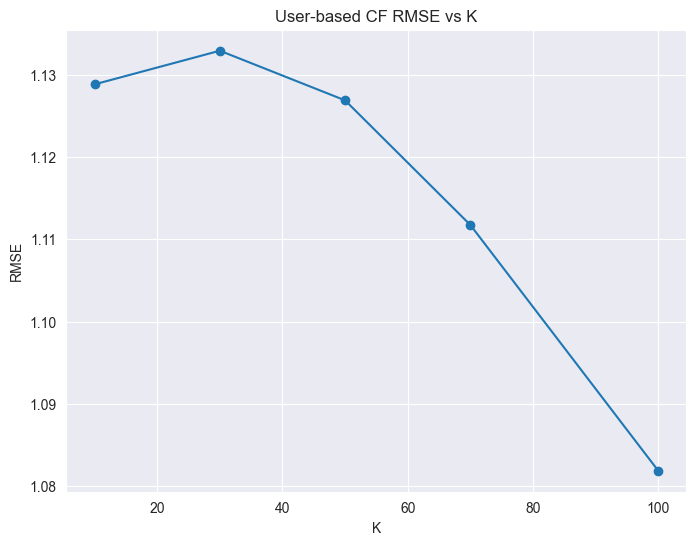

In [40]:
K = [10,30,50,70,100]

data_path = "artifacts/fine_tuning/user_based_cf_rmse_vs_k.pkl"
if os.path.exists(data_path):
    user_based_RMSEs = utils.load_embeddings(data_path)
    print("Loaded user_based_RMSEs from file.")
else:
    start_time = time.time()
    user_based_RMSEs = []
    for k in K:
        print(f'Computing RMSE for k={k}...')
        user_based_RMSEs.append(evaluate_user_cf_rating_prediction(train_data, test_data, user_similarity_matrix, k))
    utils.save_embeddings(user_based_RMSEs, data_path)
    end_time = time.time()
    print(f'Running time: {end_time - start_time:.4f} seconds')
    
plot(K, user_based_RMSEs, 'User-based CF RMSE vs K', 'K', 'RMSE')
best_params['user_k'] = K[np.argmin(user_based_RMSEs)]

## 1.3 Item-based Collaborative Filtering

### 1.3.1 Cosine similarity

In [41]:
def cosine_similarity(item1_ratings: pd.Series, item2_ratings: pd.Series) -> float:
    """
    Compute cosine similarity between two items' rating vectors.
    Only common users are considered.
    
    Parameters:
    - item1_ratings, item2_ratings: pd.Series indexed by user_id
    
    Returns:
    - float: cosine similarity between -1 and 1
    """
    result = 0.0

    i1, i2 = item1_ratings.align(item2_ratings, join='inner')
    mask = i1.notna() & i2.notna()
    x, y = i1[mask].astype(float), i2[mask].astype(float)

    # We need at least 2 ratings to compute cosine similarity
    if x.size < 2:
        return 0.0
    
    nom = (x * y).sum()
    denom = math.sqrt((x * x).sum()) * math.sqrt((y * y).sum())
    if denom == 0.0 or not np.isfinite(denom):
        return 0.0

    result = nom / denom

    return result

# Example: compute the cosine correlation between two items
item1, item2 = 1, 2
item1_ratings = train_data[train_data['item_id'] == item1].set_index('user_id')['rating']
item2_ratings = train_data[train_data['item_id'] == item2].set_index('user_id')['rating']
print(f"Cosine similarity between items {item1} and {item2} is {cosine_similarity(item1_ratings, item2_ratings):.4f}")

Cosine similarity between items 1 and 2 is 0.9500


### 1.3.2 Item-item similarity matrix

In [42]:
def compute_item_similarity_matrix(train_data: pd.DataFrame) -> pd.DataFrame:
    """
    Compute item-item similarity matrix using cosine similarity.
    
    Parameters:
    - ratings: pd.DataFrame with columns ['user_id', 'item_id', 'rating']
    
    Returns:
    - pd.DataFrame: item-item similarity matrix (rows & cols = item_ids)
    """
    items = train_data['item_id'].unique()
    item_similarity_matrix = pd.DataFrame(np.zeros((len(items), len(items))), index=items, columns=items)

    # pre-compute user ratings
    item_ratings = { i: train_data.loc[train_data['item_id'] == i, ['user_id', 'rating']].set_index('user_id')['rating']
                     for i in items }

    for i, item1 in enumerate(items):
        item1_ratings = item_ratings[item1]
        for j in range(i + 1, len(items)): # only compute for upper triangle (excluding diagonal)
            item2 = items[j]
            item2_ratings = item_ratings[item2]
            sim = cosine_similarity(item1_ratings, item2_ratings)

            item_similarity_matrix.iat[i, j] = sim
            item_similarity_matrix.iat[j, i] = sim # fill in lower triangle
    
    return item_similarity_matrix

item_similarity_matrix_path = "artifacts/similarity/item_similarity_matrix.pkl"

if os.path.exists(item_similarity_matrix_path):
    with open(item_similarity_matrix_path, "rb") as f:
        item_similarity_matrix = pickle.load(f)
    print("Loaded item_similarity_matrix from file.")   
else:
    start_time = time.time()
    item_similarity_matrix = compute_item_similarity_matrix(train_data)  
    end_time = time.time()
    print(f'Running time: {end_time - start_time:.4f} seconds')
    
    with open(item_similarity_matrix_path, "wb") as f:
        pickle.dump(item_similarity_matrix, f)
        print("Computed and saved item_similarity_matrix.")

Loaded item_similarity_matrix from file.


### 1.3.3 Predicting the rating for a target user and target item using the item-item similarity matrix

In [43]:
def get_k_item_neighbors(item_similarity_matrix: pd.DataFrame, target_item, k=5):
    """
    Retrieve top-k most similar items to the target item.
    
    Parameters:
    - item_similarity_matrix: pd.DataFrame, item-item similarity
    - target_item: item ID
    - k: number of neighbors
    
    Returns:
    - List of tuples: [(neighbor_item_id, similarity), ...]
    """
    top_k_neighbors = []

    if target_item not in item_similarity_matrix.columns:
        return []

    sorted_neighbors = item_similarity_matrix[target_item].sort_values(ascending=False)
    top_neighbors = sorted_neighbors[:k]
    for neighbor, sim in top_neighbors.items():
        top_k_neighbors.append((neighbor, sim))
    
    return top_k_neighbors

# Example: get the top-k most similar items to a particular item
target_item, k = 1, 10
print(f"Neighbors of item {target_item} are:")
get_k_item_neighbors(item_similarity_matrix, target_item, k)

Neighbors of item 1 are:


[(1534, 1.0),
 (1024, 1.0),
 (1150, 1.0),
 (1445, 1.0),
 (757, 1.0),
 (938, 1.0),
 (954, 0.9999999999999999),
 (1189, 0.9999999999999999),
 (592, 0.9999999999999999),
 (1087, 0.9999999999999998)]

In [44]:
def predict_rating_item_based(train_data: pd.DataFrame, item_similarity_matrix: pd.DataFrame, target_user, target_item, k=5):
    """
    Predict rating using item-based CF (non-mean centric).
    
    Parameters:
    - ratings: pd.DataFrame ['user_id', 'item_id', 'rating']
    - item_similarity_matrix: item-item similarity DataFrame
    - target_user: user ID
    - target_item: item ID
    - k: number of neighbors to use
    
    Returns:
    - float: predicted rating, or np.nan if not enough data
    """
    result = 0.0

    if target_item not in item_similarity_matrix.columns:
        return train_data[train_data['user_id'] == target_user]['rating'].mean() # Return user mean rating

    top_k_neighbors = get_k_item_neighbors(item_similarity_matrix, target_item, k)
    selected_neighbors = [] # In this case, neighbors are the items
    for item_neighbor, sim in top_k_neighbors:
        # If the target user has rated the neighbor item
        if item_neighbor in train_data[train_data['user_id'] == target_user]['item_id'].unique():
            neighbor_rating = train_data[(train_data['user_id'] == target_user) & (train_data['item_id'] == item_neighbor)]['rating'].values[0]
            selected_neighbors.append((item_neighbor, sim, neighbor_rating))

    sim_sum = sum([abs(sim) for _, sim, _ in selected_neighbors])
    if sim_sum == 0:
        return 0.0
    
    numerator = 0.0
    # Calculate the weighted average rating based on the similarity scores of the neighbors
    for _, sim, neighbor_rating in selected_neighbors:
        numerator += sim * neighbor_rating

    result += numerator / sim_sum

    # Normalize to [0,5] range
    user_mask = (train_data['user_id'] == target_user)
    src = train_data.loc[user_mask, 'rating']
    src_min = src.min() if not src.empty else None
    src_max = src.max() if not src.empty else None
    if src_min is None or src_max is None or not np.isfinite(src_min) or not np.isfinite(src_max):
        # fallback to global
        src_min = train_data['rating'].min()
        src_max = train_data['rating'].max()

    normalized_result = minmax_scale(result, src_min, src_max, 1.0, 5.0)
    
    return normalized_result

# Example: predict the rating a particular user would give to a particular item using item-based CF
target_user, target_item, k = 1, 17, 50
print(f"The actual rating for user {target_user} and item {target_item} is 3. The predicted rating by item-based CF for user {target_user} and item {target_item} is {predict_rating_item_based(train_data, item_similarity_matrix, target_user, target_item, k):.4f}")

The actual rating for user 1 and item 17 is 3. The predicted rating by item-based CF for user 1 and item 17 is 2.3376


### 1.2.4 Recommending top-k items using item-based CF

In [45]:
def recommend_topk_item_based(train_data, item_similarity_matrix, target_user, k=5, n=10):
    """
    Generate Top-K recommendations for a target user using Item-based CF.
    
    Args:
        train_data (pd.DataFrame): ratings data with columns [user_id, item_id, rating]
        item_similarity_matrix (pd.DataFrame): precomputed item-item similarity matrix
        target_user (int): user_id of the target user
        k (int): number of items to recommend
    
    Returns:
        list of (item_id, predicted_score) sorted by score desc
    """

    # Items already rated by the target user (exclude from recommendations)
    rated_items = set(train_data.loc[train_data['user_id'] == target_user, 'item_id'].unique())

    # Candidate items 
    all_items = train_data['item_id'].unique()
    candidate_items = [it for it in all_items if it not in rated_items]

    preds = []
    for item in candidate_items:
        pred_score = predict_rating_item_based(train_data, item_similarity_matrix, target_user, item, k) # Here, k is the number of neighbors used for score predictions
        if np.isfinite(pred_score):
            preds.append((item, float(pred_score)))

    preds.sort(key=lambda x: x[1], reverse=True)    
    return preds[:n]

# Example: get top-k recommendations for a particular user, using item-based CF
target_user, k = 1, 50
recommendations = recommend_topk_item_based(train_data, item_similarity_matrix, target_user, k)
print(f"Top-10 recommendations for user {target_user}:")
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")

Top-10 recommendations for user 1:
Item 272: 5.0000
Item 291: 5.0000
Item 309: 5.0000
Item 329: 5.0000
Item 327: 5.0000
Item 174: 5.0000
Item 375: 5.0000
Item 383: 5.0000
Item 392: 5.0000
Item 415: 5.0000


### 1.3.5 Evaluation of Item-based Model

#### 1.3.5.1 Evaluation of Item-based Prediction Task

In [46]:
def evaluate_item_cf_rating_prediction(train_data: pd.DataFrame, test_data: pd.DataFrame, item_similarity_matrix: pd.DataFrame, k=5) -> float:
    """
    Evaluate item-based CF using RMSE on a test set.
    
    Parameters:
    - train_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for training
    - test_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for testing
    - item_similarity_matrix: item-item similarity matrix (computed from train set)
    - k: number of neighbors
    
    Returns:
    - float: RMSE value
    """
    result = 0.0

    # Compute RMSE as we go, for efficiency
    sum_diff = 0.0
    for row in test_data.itertuples():
        user = row.user_id
        target_item = row.item_id
        pred = predict_rating_item_based(train_data, item_similarity_matrix, user, target_item, k)
        sum_diff += (row.rating - pred) ** 2
    result = np.sqrt(sum_diff / len(test_data))

    return result

#### 1.3.5.2 Evaluation of Item-based Ranking Task

In [54]:
def evaluate_item_cf_ranking(train_data, test_data, item_similarity_matrix, k=5):
    """
    Evaluate Item-based CF ranking performance using NDCG@K.
    
    Args:
        train_data (pd.DataFrame): training ratings [user_id, item_id, rating]
        test_data (pd.DataFrame): test ratings [user_id, item_id, rating]
        item_similarity_matrix (pd.DataFrame): precomputed item-item similarity matrix
        k (int): number of neighbors for prediction
    
    Returns:
        float: average NDCG@K across test users
    """

    ground_truth, rec_list = [], []
    test_users = test_data['user_id'].unique()

    # Loop over the first 20 test users to compute the NDCG (otherwise it will take too long)
    for i, test_user_id in enumerate(test_users[:batch_size_ranking_eval]):
        # Step 1. Compute ground truth - all the items this user interacted with in the test set
        curr_gt = test_data[test_data['user_id'] == test_user_id]['item_id']
        ground_truth.append(curr_gt)

        # Step 2. Get the recommendation list for this user
        curr_rec = recommend_topk_item_based(train_data, user_similarity_matrix, test_user_id, k=k)
        rec_list.append([item for item, _ in curr_rec]) # Only append item ids

        print(f"Test user {i + 1} is processed.")
    
    return {
        'precision': Precision(ground_truth, rec_list),
        'recall':    Recall(ground_truth, rec_list),
        'ndcg':      NDCG(ground_truth, rec_list),
        'mrr':       MRR(ground_truth, rec_list),
        'map':       MAP(ground_truth, rec_list)
    }

### 1.3.6 Finetuning the hyperparameter k for item-based CF

Embeddings loaded from artifacts/fine_tuning/item_based_cf_rmse_vs_k.pkl
Loaded item_based_RMSEs from file.


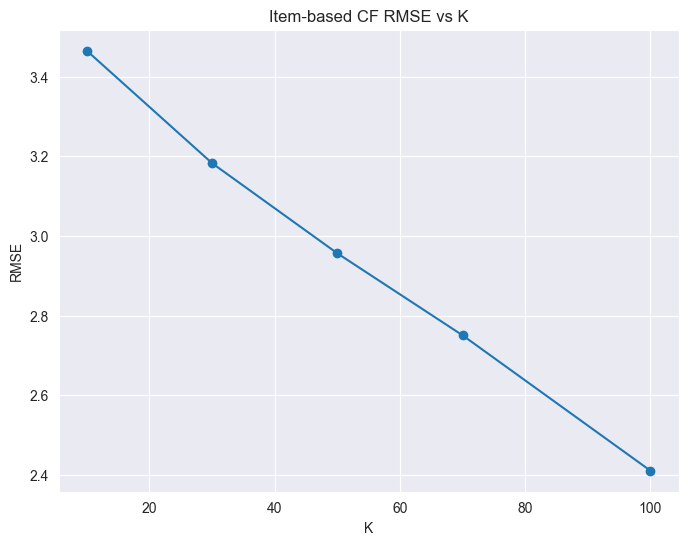

In [48]:
K = [10,30,50,70,100]

data_path = "artifacts/fine_tuning/item_based_cf_rmse_vs_k.pkl"
if os.path.exists(data_path):
    item_based_RMSEs = utils.load_embeddings(data_path)
    print("Loaded item_based_RMSEs from file.")
else:
    start_time = time.time()
    item_based_RMSEs = []
    for k in K:
        print(f'Computing RMSE for k={k}...')
        item_based_RMSEs.append(evaluate_item_cf_rating_prediction(train_data, test_data, item_similarity_matrix, k))
    utils.save_embeddings(item_based_RMSEs, data_path)
    end_time = time.time()
    print(f'Running time: {end_time - start_time:.4f} seconds')

plot(K, item_based_RMSEs, 'Item-based CF RMSE vs K', 'K', 'RMSE')
best_params['item_k'] = K[np.argmin(item_based_RMSEs)]

## 1.4 Matrix Factorization

### 1.4.1 Model Definition

In [49]:
class MatrixFactorizationSGD:
    """
    Matrix Factorization for rating prediction using Stochastic Gradient Descent (SGD).
    
    Rating matrix R ≈ P x Q^T + biases
    """
    def __init__(self, n_factors=20, learning_rate=0.01, regularization=0.02, n_epochs=20, use_bias=True):
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.n_epochs = n_epochs
        self.use_bias = use_bias

        # Model parameters
        self.P = None  # User latent factors
        self.Q = None  # Item latent factors
        self.user_bias = None
        self.item_bias = None
        self.global_mean = None

    def fit(self, ratings, verbose=True):
        """
        Train the model.
        
        Args:
            ratings (pd.DataFrame): dataframe with [user_id, item_id, rating]
        """
        # Map IDs to indices
        self.user_mapping = {u: i for i, u in enumerate(ratings['user_id'].unique())}
        self.item_mapping = {i: j for j, i in enumerate(ratings['item_id'].unique())}
        self.user_inv = {i: u for u, i in self.user_mapping.items()}
        self.item_inv = {j: i for i, j in self.item_mapping.items()}

        n_users = len(self.user_mapping)
        n_items = len(self.item_mapping)

        # Initialize factors
        self.P = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.Q = np.random.normal(0, 0.1, (n_items, self.n_factors))

        if self.use_bias:
            self.user_bias = np.zeros(n_users)
            self.item_bias = np.zeros(n_items)
            self.global_mean = ratings['rating'].mean()

        # Convert to (user_idx, item_idx, rating) triples
        training_data = [(self.user_mapping[u], self.item_mapping[i], r)
                         for u, i, r in zip(ratings['user_id'], ratings['item_id'], ratings['rating'])]

        # SGD loop
        for epoch in range(self.n_epochs):
            np.random.shuffle(training_data)
            total_error = 0

            for u, i, r in training_data:
                pred = np.dot(self.P[u], self.Q[i])
                if self.use_bias:
                    pred += self.global_mean + self.user_bias[u] + self.item_bias[i]

                err = r - pred
                total_error += err ** 2

                # Updates
                P_u = self.P[u]
                Q_i = self.Q[i]

                self.P[u] += self.learning_rate * (err * Q_i - self.regularization * P_u)
                self.Q[i] += self.learning_rate * (err * P_u - self.regularization * Q_i)

                if self.use_bias:
                    self.user_bias[u] += self.learning_rate * (err - self.regularization * self.user_bias[u])
                    self.item_bias[i] += self.learning_rate * (err - self.regularization * self.item_bias[i])

            rmse = np.sqrt(total_error / len(training_data))
            if verbose:
                print(f"Epoch {epoch+1}/{self.n_epochs} - RMSE: {rmse:.4f}")

        return self

    def predict_single(self, user_id, item_id):
        """Predict rating for a single (user, item) pair"""
        if user_id not in self.user_mapping or item_id not in self.item_mapping:
            return np.nan

        u = self.user_mapping[user_id]
        i = self.item_mapping[item_id]

        pred = np.dot(self.P[u], self.Q[i])
        if self.use_bias:
            pred += self.global_mean + self.user_bias[u] + self.item_bias[i]
        return pred

    def predict(self, test_data):
        """Predict ratings for a test dataframe with [user_id, item_id]"""
        preds = []
        for u, i in zip(test_data['user_id'], test_data['item_id']):
            preds.append(self.predict_single(u, i))
        return np.array(preds)

    def recommend_topk(self, user_id, train_data, n=10, exclude_seen=True):
        """
        Generate Top-K recommendations for a given user.

        Args:
            user_id (int): target user ID (original ID, not index).
            train_data (pd.DataFrame): training ratings [user_id, item_id, rating],
                                       used to exclude already-seen items.
            k (int): number of recommendations.
            exclude_seen (bool): whether to exclude items the user already rated.

        Returns:
            list of (item_id, predicted_score) sorted by score desc.
        """
        if user_id not in self.user_mapping:
            return []

        u = self.user_mapping[user_id]

        # Predict scores for all items
        scores = np.dot(self.P[u], self.Q.T)
        if self.use_bias:
            scores += self.global_mean + self.user_bias[u] + self.item_bias

        # Exclude seen items
        if exclude_seen:
            seen_items = train_data[train_data['user_id'] == user_id]['item_id'].values
            seen_idx = [self.item_mapping[i] for i in seen_items if i in self.item_mapping]
            scores[seen_idx] = -np.inf

        # Get top-K items
        top_idx = np.argsort(scores)[::-1][:n]
        top_items = [self.item_inv[i] for i in top_idx]
        top_scores = scores[top_idx]

        return list(zip(top_items, top_scores))

In [50]:
""" MF for prediction task """

# Train model 
# Parameters: n_factors refers to embedding size, n_epochs refers to number of epochs, learning_rate refers to learning rate, and regularization refers to lambda hyperparameter controlling the effect of regularization terms
mf = MatrixFactorizationSGD(n_factors=50, n_epochs=10, learning_rate=0.001, regularization=0.001)
mf.fit(train_data, verbose=True)

# predict the rating for a target user and a target item
target_user = 1
target_item = 17
actual_rating = 3
pred_rating = mf.predict_single(target_user, target_item)
print(f"The actual rating for user {target_user} and item {target_item} is 3. The predicted rating by MF for user {target_user} and item {target_item} is {pred_rating:.4f}")

Epoch 1/10 - RMSE: 1.0961
Epoch 2/10 - RMSE: 1.0568
Epoch 3/10 - RMSE: 1.0307
Epoch 4/10 - RMSE: 1.0120
Epoch 5/10 - RMSE: 0.9979
Epoch 6/10 - RMSE: 0.9868
Epoch 7/10 - RMSE: 0.9778
Epoch 8/10 - RMSE: 0.9703
Epoch 9/10 - RMSE: 0.9639
Epoch 10/10 - RMSE: 0.9584
The actual rating for user 1 and item 17 is 3. The predicted rating by MF for user 1 and item 17 is 3.4415


In [51]:
""" MF for ranking task """

# Train model 
# Parameters: n_factors refers to embedding size, n_epochs refers to number of epochs, learning_rate refers to learning rate, and regularization refers to lambda hyperparameter controlling the effect of regularization terms
mf = MatrixFactorizationSGD(n_factors=10, n_epochs=10, learning_rate=0.001, regularization=0.001)
mf.fit(train_data, verbose=True)

# Get top-10 recommendations for user 1
recommendations = mf.recommend_topk(user_id=1, train_data=train_data, n=10)
print("Top-10 Recommendations for user 1:")
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")

Epoch 1/10 - RMSE: 1.0941
Epoch 2/10 - RMSE: 1.0557
Epoch 3/10 - RMSE: 1.0304
Epoch 4/10 - RMSE: 1.0124
Epoch 5/10 - RMSE: 0.9990
Epoch 6/10 - RMSE: 0.9887
Epoch 7/10 - RMSE: 0.9804
Epoch 8/10 - RMSE: 0.9736
Epoch 9/10 - RMSE: 0.9680
Epoch 10/10 - RMSE: 0.9632
Top-10 Recommendations for user 1:
Item 318: 4.4766
Item 64: 4.3986
Item 12: 4.3660
Item 98: 4.3590
Item 483: 4.3571
Item 174: 4.3407
Item 357: 4.3146
Item 313: 4.2842
Item 302: 4.2455
Item 134: 4.2326


### 1.4.2 Evaluation of MF

#### 1.4.2.1 Evaluation of MF on Rating Task

In [52]:
def evaluate_mf_rating_prediction(train_data: pd.DataFrame, test_data: pd.DataFrame, n_factors: float, n_epochs: float, learning_rate: float) -> float:
    """
    Evaluate MF using RMSE on a test set.
    
    Parameters:
    - train_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for training
    - test_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for testing
    - n_factors: embedding size
    - n_epochs: number of training epochs
    - learning_rate: Learning rate
    
    Returns:
    - float: RMSE value
    """
    result = 0.0

    # Train model 
    # Parameters: n_factors refers to embedding size, n_epochs refers to number of epochs, learning_rate refers to learning rate, and regularization refers to lambda hyperparameter controlling the effect of regularization terms
    mf = MatrixFactorizationSGD(n_factors=50, n_epochs=30, learning_rate=0.001, regularization=0.001)
    mf.fit(train_data, verbose=True)
    preds = mf.predict(test_data)
    y_true = test_data['rating'].values

    # Fallbacks for NaN predictions 
    user_means = train_data.groupby('user_id')['rating'].mean()
    
    if np.isnan(preds).any():
        filled = []
        for (u, _), p in zip(test_data[['user_id', 'item_id']].itertuples(index=False, name=None), preds):
            if np.isfinite(p):
                filled.append(p)
            else:
                m = user_means.get(u, np.nan)
                filled.append(float(m))
        preds = np.array(filled, dtype=float)
    
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    
    return rmse

#### 1.4.2.2 Evaluation of MF on Ranking Task

In [71]:
def evaluate_mf_ranking(train_data: pd.DataFrame, test_data: pd.DataFrame, n_factors: float, n_epochs: float, learning_rate: float):
    """
    Evaluate MF in terms of NDCG.
    
    Parameters:
    - train_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for training
    - test_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for testing
    - n_factors: embedding size
    - n_epochs: number of training epochs
    - learning_rate: Learning rate
    
    Returns:
    - float: NDCG value
    """
    # Hint: set the regularization hyperparameter to 0.001

    ############# Your code here ############

    # Train model 
    # Parameters: n_factors refers to embedding size, n_epochs refers to number of epochs, learning_rate refers to learning rate, and regularization refers to lambda hyperparameter controlling the effect of regularization terms
    mf = MatrixFactorizationSGD(n_factors=n_factors, learning_rate=learning_rate, n_epochs=n_epochs, regularization=0.001)
    mf.fit(train_data, verbose=True)

    ground_truth, rec_list = [], []
    test_users = test_data['user_id'].unique()

    # Loop over the first 20 test users to compute the NDCG (otherwise it will take too long)
    for i, test_user_id in enumerate(test_users[:batch_size_ranking_eval]):
        # Step 1. Compute ground truth - all the items this user interacted with in the test set
        curr_gt = test_data[test_data['user_id'] == test_user_id]['item_id']
        ground_truth.append(curr_gt)

        # Step 2. Get the recommendation list for this user
        curr_rec = mf.recommend_topk(user_id=1, train_data=train_data, n=10)
        rec_list.append([item for item, _ in curr_rec]) # Only append item ids

        #print(rec_list)
        print(f"Test user {i + 1} is processed.")

    #########################################
    
    return {
        'precision': Precision(ground_truth, rec_list),
        'recall':    Recall(ground_truth, rec_list),
        'ndcg':      NDCG(ground_truth, rec_list),
        'mrr':       MRR(ground_truth, rec_list),
        'map':       MAP(ground_truth, rec_list)
    }

### 1.4.3 Fine tuning of ML

Embeddings loaded from artifacts/fine_tuning/mf_rmse_vs_n_factors.pkl
Loaded mf_RMSEs from file.


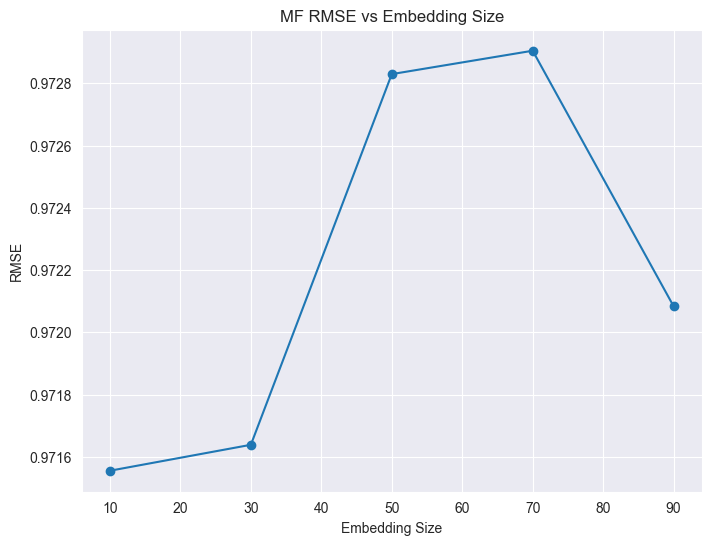

In [56]:
# fine-tuning the embedding size hyperparameter
n_factors = [10,30,50,70,90]
n_epochs, learning_rate = 30, 0.001
mf_RMSEs = []

data_path = "artifacts/fine_tuning/mf_rmse_vs_n_factors.pkl"
if os.path.exists(data_path):
    mf_RMSEs = utils.load_embeddings(data_path)
    print("Loaded mf_RMSEs from file.")
else:
    start_time = time.time()
    mf_RMSEs = [evaluate_mf_rating_prediction(train_data, test_data, n, n_epochs, learning_rate) for n in n_factors]
    utils.save_embeddings(mf_RMSEs, data_path)
    end_time = time.time()
    print(f'Running time: {end_time - start_time:.4f} seconds')
plot(n_factors, mf_RMSEs, 'MF RMSE vs Embedding Size', 'Embedding Size', 'RMSE')
best_params['mf_n_factors'] = n_factors[np.argmin(mf_RMSEs)]

Embeddings loaded from artifacts/fine_tuning/mf_rmse_vs_n_epochs.pkl
Loaded mf_RMSEs from file.


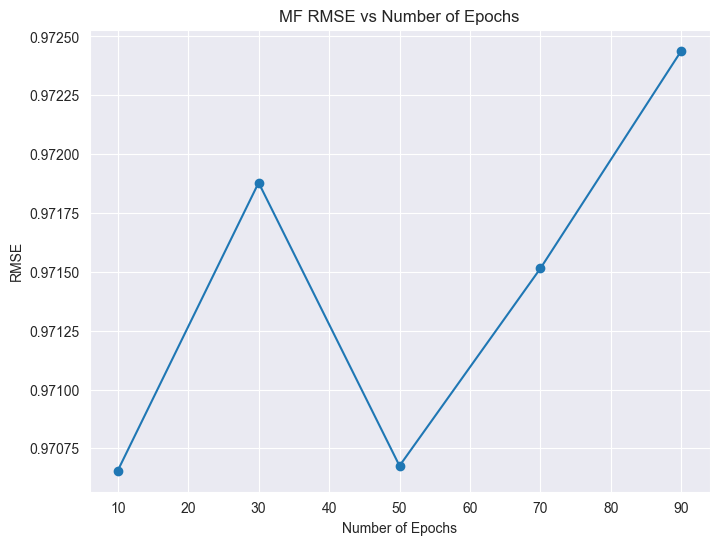

In [57]:
# fine-tuning the number of epochs hyperparameter
n_epochs = [10,30,50,70,90]
n_factors, learning_rate = 10, 0.001
mf_RMSEs = []

data_path = "artifacts/fine_tuning/mf_rmse_vs_n_epochs.pkl"
if os.path.exists(data_path):
    mf_RMSEs = utils.load_embeddings(data_path)
    print("Loaded mf_RMSEs from file.")
else:
    start_time = time.time()
    mf_RMSEs = [evaluate_mf_rating_prediction(train_data, test_data, n_factors, n, learning_rate) for n in n_epochs]
    utils.save_embeddings(mf_RMSEs, data_path)
    end_time = time.time()
    print(f'Running time: {end_time - start_time:.4f} seconds')
    
plot(n_epochs, mf_RMSEs, 'MF RMSE vs Number of Epochs', 'Number of Epochs', 'RMSE')
best_params['mf_n_epochs'] = n_epochs[np.argmin(mf_RMSEs)]

Embeddings loaded from artifacts/fine_tuning/mf_rmse_vs_learning_rate.pkl
Loaded mf_RMSEs from file.


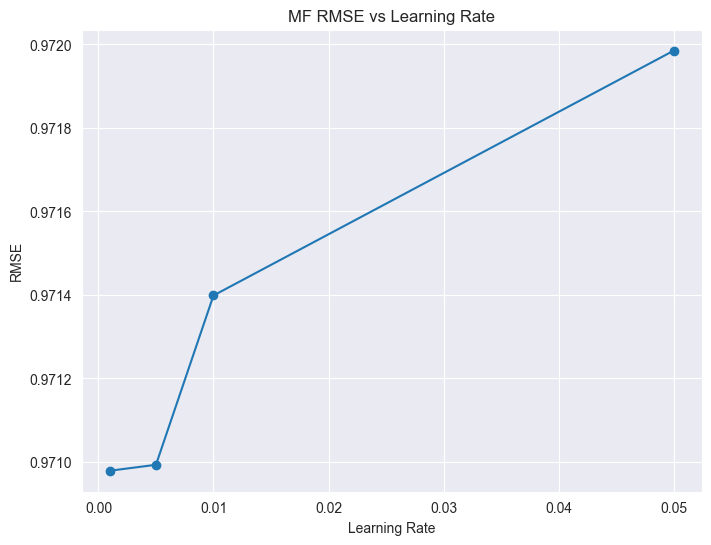

In [58]:
# fine-tuning the learning rate hyperparameter
learning_rate = [0.001,0.005,0.01,0.05]
n_factors, n_epochs = 10, 90
mf_RMSEs = []

data_path = "artifacts/fine_tuning/mf_rmse_vs_learning_rate.pkl"
if os.path.exists(data_path):
    mf_RMSEs = utils.load_embeddings(data_path)
    print("Loaded mf_RMSEs from file.")
else:
    start_time = time.time()
    mf_RMSEs = [evaluate_mf_rating_prediction(train_data, test_data, n_factors, n_epochs, lr) for lr in learning_rate]
    utils.save_embeddings(mf_RMSEs, data_path)
    end_time = time.time()
    print(f'Running time: {end_time - start_time:.4f} seconds')

plot(learning_rate, mf_RMSEs, 'MF RMSE vs Learning Rate', 'Learning Rate', 'RMSE')
best_params['mf_lr'] = learning_rate[np.argmin(mf_RMSEs)]

## 1.5 Bayesian Personalized Ranking(BPR)

### 1.5.1 Create User Binary Preferences Matrix / Triples

In [59]:
def compute_user_preferences_matrix(train_data: pd.DataFrame, user_id: int) -> pd.DataFrame:
    """
    For each user, create a n*n matrix of binary preferences based on comparison between items,
    where n is the number of all items from the training data.

    Parameters:
    - train_data: pd.DataFrame
    - user_id: target user ID

    Returns:
    - pd.DataFrame with rows and columns as item IDs and values as 
        (1). 1 (item1 preferred over item2) 
        (2). -1 (item2 preferred over item1)
        (3). 0 (unknown preference)
    """
    items = train_data['item_id'].unique()
    n_items = len(items)
    item_index = {item: idx for idx, item in enumerate(items)}
    matrix = np.zeros((n_items, n_items), dtype=int)

    user_ratings = train_data[train_data['user_id'] == user_id][['item_id', 'rating']]
    for i, row1 in user_ratings.iterrows():
        item1, rating1 = row1['item_id'], row1['rating']
        for j, row2 in user_ratings.iterrows():
            if i >= j:
                continue
            item2, rating2 = row2['item_id'], row2['rating']
            if rating1 > rating2:
                matrix[item_index[item1], item_index[item2]] = 1
            elif rating1 < rating2:
                matrix[item_index[item2], item_index[item1]] = -1
    return matrix

user_id = 1
user_preferences = compute_user_preferences_matrix(train_data, user_id)
print(f"User {user_id} preferences matrix:")
print(len(user_preferences), user_preferences)

User 1 preferences matrix:
1650 [[ 0  1  1 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0 -1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [60]:
from itertools import combinations

def compute_user_preferences_triples(train_data: pd.DataFrame, user_id: int):
    """
    For a given user, return a list of (user, pos_item, neg_item) triples
    where the user prefers pos_item over neg_item.
    """
    
    user_ratings = train_data.loc[train_data['user_id'] == user_id, ['item_id', 'rating']]
    triples = []

    if user_ratings.shape[0] < 2:
        return triples

    records = user_ratings.values.tolist()  # list of [item_id, rating]
    for (item1, r1), (item2, r2) in combinations(records, 2):
        if r1 > r2:
            triples.append((user_id, int(item1), int(item2)))  # user, pos, neg
        elif r2 > r1:
            triples.append((user_id, int(item2), int(item1)))

    return triples

In [61]:
user_preferences_path = "artifacts/preferences/user_preferences_triples.pkl"
if os.path.exists(user_preferences_path):
    user_preferences_triples = utils.load_embeddings(user_preferences_path)
    print("Loaded user_preferences_triples from file.")
else:
    users = train_data['user_id'].unique()
    user_preferences_triples = []
    for user in users:
        user_preferences_triples.extend(compute_user_preferences_triples(train_data, user))
    print(f"Total number of preference triples: {len(user_preferences_triples)}")
    utils.save_embeddings(user_preferences_triples, user_preferences_path)
    print("Computed and saved user_preferences_triples.")

Embeddings loaded from artifacts/preferences/user_preferences_triples.pkl
Loaded user_preferences_triples from file.


In [62]:
from sklearn.preprocessing import LabelEncoder

def encode_data(train_data, triples):
    '''
    Encode target labels with value between 0 and n_classes-1 to generate compact representations.
    '''
    
    u_enc_path = "artifacts/encoders/user_encoder.pkl"
    i_enc_path = "artifacts/encoders/item_encoder.pkl"
    enc_triples_path = "artifacts/encoders/encoded_triples.pkl"
    if os.path.exists(u_enc_path) and os.path.exists(i_enc_path) and os.path.exists(enc_triples_path):
        u_enc = utils.load_embeddings(u_enc_path)
        i_enc = utils.load_embeddings(i_enc_path)
        enc_triples = utils.load_embeddings(enc_triples_path)
        print("Loaded encoders and encoded_triples from file.")
        return u_enc, i_enc, enc_triples
    else:
        os.makedirs("artifacts/encoders", exist_ok=True)
        u_enc = LabelEncoder().fit(train_data['user_id'])
        i_enc = LabelEncoder().fit(train_data['item_id'])
        enc_triples = [(u_enc.transform([u])[0],
                        i_enc.transform([i])[0],
                        i_enc.transform([j])[0]) for (u,i,j) in triples]
        print("Encoded triples done.")

        utils.save_embeddings(u_enc, u_enc_path)
        utils.save_embeddings(i_enc, i_enc_path)
        utils.save_embeddings(enc_triples, enc_triples_path)
        print("Saved encoders and encoded_triples to file.")
    
        return u_enc, i_enc, enc_triples
    
encode_data(train_data, user_preferences_triples)

Embeddings loaded from artifacts/encoders/user_encoder.pkl
Embeddings loaded from artifacts/encoders/item_encoder.pkl
Embeddings loaded from artifacts/encoders/encoded_triples.pkl
Loaded encoders and encoded_triples from file.


(LabelEncoder(),
 LabelEncoder(),
 [(np.int64(0), np.int64(0), np.int64(1)),
  (np.int64(0), np.int64(0), np.int64(2)),
  (np.int64(0), np.int64(0), np.int64(3)),
  (np.int64(0), np.int64(0), np.int64(4)),
  (np.int64(0), np.int64(0), np.int64(6)),
  (np.int64(0), np.int64(0), np.int64(7)),
  (np.int64(0), np.int64(0), np.int64(10)),
  (np.int64(0), np.int64(0), np.int64(17)),
  (np.int64(0), np.int64(0), np.int64(20)),
  (np.int64(0), np.int64(0), np.int64(21)),
  (np.int64(0), np.int64(0), np.int64(24)),
  (np.int64(0), np.int64(0), np.int64(25)),
  (np.int64(0), np.int64(0), np.int64(27)),
  (np.int64(0), np.int64(0), np.int64(28)),
  (np.int64(0), np.int64(0), np.int64(29)),
  (np.int64(0), np.int64(0), np.int64(33)),
  (np.int64(0), np.int64(0), np.int64(34)),
  (np.int64(0), np.int64(0), np.int64(36)),
  (np.int64(0), np.int64(0), np.int64(37)),
  (np.int64(0), np.int64(0), np.int64(39)),
  (np.int64(0), np.int64(0), np.int64(40)),
  (np.int64(0), np.int64(0), np.int64(42)),
  (n

### 1.5.2 Train the BPR model

In [63]:
class BPR:
    def __init__(self, n_users, n_items, f=32, lr=0.05, regulation=0.01, seed=10):
        rng = np.random.default_rng(seed)
        self.P = rng.normal(0, 0.1, (n_users, f)) # user latent matrix, shape (n_users, f)
        self.Q = rng.normal(0, 0.1, (n_items, f)) # item latent matrix, shape (n_items, f)
        self.lr, self.regulation = lr, regulation
        self.rng = rng

    def _sigmoid(self, x): 
        return 1/(1+np.exp(-x))

    def fit(self, triples, epochs=10, verbose=True):
        """
        triples: list of (u_idx, i_idx, j_idx) where indices are integers
        """
        if len(triples) == 0:
            if verbose:
                print("No training triples provided.")
            return self

        triples = np.array(triples, dtype=int)
        n = len(triples)

        for epoch in tqdm(range(epochs), desc="BPR Training"):
            perm = self.rng.permutation(n)
            for idx in tqdm(perm, desc="Epoch Progress", leave=False):
                u, i, j = triples[idx]
                x = np.dot(self.P[u], self.Q[i] - self.Q[j])
                s = self._sigmoid(-x)

                # gradients
                gradP = s * (self.Q[i] - self.Q[j]) - self.regulation * self.P[u]
                gradQi = s * self.P[u] - self.regulation * self.Q[i]
                gradQj = -s * self.P[u] - self.regulation * self.Q[j]

                # parameter updates
                self.P[u] += self.lr * gradP
                self.Q[i] += self.lr * gradQi
                self.Q[j] += self.lr * gradQj

            if verbose:
                print(f"Epoch {epoch+1}/{epochs} completed.")
        return self
    
    def score(self, u): 
        # the predicted scores for all items for user u
        return self.P[u] @ self.Q.T
    
    def predict(self, u, i):
        # predict the score for user u and item i
        return self.P[u] @ self.Q[i]


In [64]:
# Encode the training data and the preference triples
u_enc,i_enc,enc_triples = encode_data(train_data, user_preferences_triples)

# Train the BPR model
bpr_model_path = "artifacts/bpr_model.joblib"
if os.path.exists(bpr_model_path):
    bpr = joblib.load(bpr_model_path)
    print("Loaded BPR model from file.")
else:
    bpr = BPR(len(u_enc.classes_),len(i_enc.classes_))
    bpr.fit(enc_triples, epochs=5)
    joblib.dump(bpr, bpr_model_path)
    print("Computed and saved BPR model.")


Embeddings loaded from artifacts/encoders/user_encoder.pkl
Embeddings loaded from artifacts/encoders/item_encoder.pkl
Embeddings loaded from artifacts/encoders/encoded_triples.pkl
Loaded encoders and encoded_triples from file.
Loaded BPR model from file.


### 1.5.3 Score prediction of BPR


In [65]:
def predict_score_bpr(bpr, u_enc, i_enc, user_id, item_id):
    if user_id not in u_enc.classes_ or item_id not in i_enc.classes_:
        return np.nan
    u = u_enc.transform([user_id])[0]
    i = i_enc.transform([item_id])[0]
    return bpr.predict(u, i)

In [66]:
from scipy.special import expit 

def predict_score_bpr_scaled(bpr, u_enc, i_enc, user_id, item_id):
    if user_id not in u_enc.classes_ or item_id not in i_enc.classes_:
        return np.nan

    u = u_enc.transform([user_id])[0]
    i = i_enc.transform([item_id])[0]

    raw_score = bpr.predict(u, i)  # raw BPR score

    if not np.isfinite(raw_score):
        return np.nan

    # Sigmoid to (0,1), then scale to range [1,5]: 1 + 4 * σ(score)
    scaled_score = 1.0 + 4.0 * expit(raw_score)

    return float(scaled_score)

In [67]:
# Sample prediction for user 1 and item 17
user_id = 1
item_id = 17
print(f"The predicted score for user {user_id} and item {item_id} is {predict_score_bpr(bpr, u_enc, i_enc, user_id, item_id):.4f}")
print(f"The 'normalized' predicted score for user {user_id} and item {item_id} is {predict_score_bpr_scaled(bpr, u_enc, i_enc, user_id, item_id):.4f}")

The predicted score for user 1 and item 17 is 1.4826
The 'normalized' predicted score for user 1 and item 17 is 4.2598


### 1.5.4 Evaluation of BPR on Ranking Task

In [74]:
def recommend(bpr, u_enc, i_enc, user_id, train_data, k=10, exclude_seen=True):
    """
    Generate top-k recommendations for a user using BPR.
    
    Args:
        bpr: trained BPR model
        u_enc: user label encoder
        i_enc: item label encoder
        user_id: target user ID
        train_data: training DataFrame to identify seen items
        k: number of recommendations
        exclude_seen: whether to exclude items the user already rated
    
    Returns:
        numpy array of item IDs
    """
    u = u_enc.transform([user_id])[0]
    scores = bpr.score(u)
    
    # Exclude items already rated by the user
    if exclude_seen:
        seen_items = train_data[train_data['user_id'] == user_id]['item_id'].values
        seen_idx = [i_enc.transform([item])[0] for item in seen_items if item in i_enc.classes_]
        scores[seen_idx] = -np.inf
    
    # Get top-k items
    top = np.argsort(-scores)[:k]
    return i_enc.inverse_transform(top)

In [75]:
# Sample recommendation for user 1
user_id = 1
k = 10
print(recommend(bpr, u_enc, i_enc, user_id, train_data, k=k, exclude_seen=True))

[318 100 483 174  64 515 313 114 408 272]


In [76]:
def evaluate_bpr_ranking(bpr, u_enc, i_enc, test_data, k=10, relevance_threshold=4):
    users = test_data['user_id'].unique()
    ground_truth = []
    rec_lists = []

    for u in users[:batch_size_ranking_eval]:  # Limit to first N users for speed
        # ground truth: items in test with rating >= threshold
        gt_items = test_data[(test_data['user_id'] == u) & (test_data['rating'] >= relevance_threshold)]['item_id'].tolist()
        if len(gt_items) == 0:
            continue
        
        if u not in u_enc.classes_:
            continue
        rec = recommend(bpr, u_enc, i_enc, u, train_data, k=k, exclude_seen=True).tolist()
        ground_truth.append(gt_items)
        rec_lists.append(rec)

    if len(ground_truth) == 0:
        return {'precision': np.nan, 'recall': np.nan, 'ndcg': np.nan, 'mrr': np.nan, 'map': np.nan}

    return {
        'precision': Precision(ground_truth, rec_lists),
        'recall':    Recall(ground_truth, rec_lists),
        'ndcg':      NDCG(ground_truth, rec_lists),
        'mrr':       MRR(ground_truth, rec_lists),
        'map':       MAP(ground_truth, rec_lists)
    }

### 1.5.5 Fine tuning of BPR

In [77]:
# Fine-tuning BPR parameters of latent factors (f)
factors_list = [16, 32, 64]
results = []

for f in factors_list:
    print(f"Training BPR: factors={f}")
    bpr = BPR(len(u_enc.classes_), len(i_enc.classes_), f=f)
    bpr.fit(enc_triples, epochs=5, verbose=False)
    metrics = evaluate_bpr_ranking(bpr, u_enc, i_enc, test_data, k=10)
    results.append({
        'factors': f,
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'ndcg': metrics['ndcg'],
        'mrr': metrics['mrr'],
        'map': metrics['map']
    })
    print(f"Precision: {metrics['precision']:.4f}, NDCG: {metrics['ndcg']:.4f}")

# Convert results to DataFrame for analysis
bpr_tuning_results = pd.DataFrame(results)
display(bpr_tuning_results)

best_params['bpr_factors'] = factors_list[np.argmax(bpr_tuning_results['ndcg'])]

Training BPR: factors=16


BPR Training: 100%|██████████| 5/5 [06:07<00:00, 73.52s/it]                 


Precision: 0.0900, NDCG: 0.1022
Training BPR: factors=32


BPR Training: 100%|██████████| 5/5 [06:10<00:00, 74.15s/it]                 


Precision: 0.1450, NDCG: 0.1417
Training BPR: factors=64


BPR Training: 100%|██████████| 5/5 [06:16<00:00, 75.37s/it]                 

Precision: 0.1400, NDCG: 0.1435


,factors,precision,recall,ndcg,mrr,map
0,16,0.090,0.014676,0.102215,0.258810,0.189945
1,32,0.145,0.020344,0.141729,0.233333,0.204087
2,64,0.140,0.018730,0.143473,0.232143,0.192161


## 1.6 Hybrid Recommender

Our *hybrid recommender* combines the predictions of the four models (content-based, user-based CF, item-based CF, and MF) using linear regression.

### 1.6.0 Print the best hyperparameters found via hyperparameter tuning

In [78]:
print("Best hyperparameters found:")
print(best_params)

Best hyperparameters found:
{'user_k': 100, 'item_k': 100, 'mf_n_factors': 10, 'mf_n_epochs': 10, 'mf_lr': 0.001, 'bpr_factors': 64}


### 1.6.1 Define the HybridLinear class

In [79]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

class HybridLinear:
    def __init__(self, 
                 coef, 
                 intercept,
                 train_data, 
                 user_similarity_matrix, 
                 item_similarity_matrix,
                 mf_model=None,
                 # BPR
                 bpr_model=None, 
                 u_enc=None, 
                 i_enc=None,
                 # Content-based parameters
                 content_type='full', 
                 aggregation_method='avg',
                 # User- & item-based CF parameters
                 k_neighbors=50, 
                 rmin=1.0, 
                 rmax=5.0,
                 # MF parameters
                 n_factors=20, 
                 learning_rate=0.01, 
                 regularization=0.02, 
                 n_epochs=20):
        
        self.coef_ = np.asarray(coef, dtype=float)
        self.intercept_ = float(intercept)
        self.train_data = train_data
        self.user_sim = user_similarity_matrix
        self.item_sim = item_similarity_matrix
        self.content_type = content_type
        self.aggregation_method = aggregation_method
        self.k = k_neighbors
        self.rmin = rmin
        self.rmax = rmax
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.n_epochs = n_epochs
        self.bpr_model = bpr_model
        self.u_enc = u_enc
        self.i_enc = i_enc

        # Precompute fallbacks
        self.global_mean = float(train_data['rating'].mean())
        self.user_mean = train_data.groupby('user_id')['rating'].mean().to_dict()
        self.item_mean = train_data.groupby('item_id')['rating'].mean().to_dict()

        # Matrix factorization model
        if mf_model is None:
            mf_model = MatrixFactorizationSGD(
                n_factors=n_factors,
                n_epochs=n_epochs,
                learning_rate=learning_rate,
                regularization=regularization
            )
            mf_model.fit(train_data, verbose=True)
        self.mf_model = mf_model
        
        # BPR model
        if bpr_model is None or (u_enc is not None and i_enc is not None):
            bpr_model = BPR(len(u_enc.classes_), len(i_enc.classes_))
            bpr_model.fit(enc_triples, epochs=5)
        self.bpr_model = bpr_model
        self.u_enc = u_enc
        self.i_enc = i_enc

    def _fallback(self, u, i):
        return self.user_mean.get(u, self.item_mean.get(i, self.global_mean))

    @staticmethod
    def _set_fallback_value(x, fallback):
        x = float(x) if x is not None else np.nan
        return fallback if (np.isnan(x) or not np.isfinite(x)) else x

    def _features_for(self, user_id, item_id):
        # 1) Content-based
        try:
            content_based = get_user_item_prediction(
                self.train_data, user_id, item_id, self.content_type, self.aggregation_method
            )
        except Exception:
            content_based = np.nan

        # 2) User-based CF
        try:
            user_based = predict_rating_user_based(
                self.train_data, self.user_sim, user_id, item_id, k=self.k
            )
        except Exception:
            user_based = np.nan

        # 3) Item-based CF
        try:
            item_based = predict_rating_item_based(
                self.train_data, self.item_sim, user_id, item_id, k=self.k
            )
        except Exception:
            item_based = np.nan

        # 4) Matrix Factorization
        try:
            mf = self.mf_model.predict_single(user_id, item_id)
        except Exception:
            mf = np.nan
            print("Failed to predict MF rating for user", user_id, "and item", item_id)

       # 5) BPR 
        try:
            bpr_score = predict_score_bpr_scaled(
                self.bpr_model, self.u_enc, self.i_enc, user_id, item_id
            )
        except Exception:
            bpr_score = np.nan
            print("Failed to predict BPR rating for user", user_id, "and item", item_id)
            

        fb = self._fallback(user_id, item_id)
        content_based = self._set_fallback_value(content_based, fb)
        user_based   = self._set_fallback_value(user_based, fb)
        item_based   = self._set_fallback_value(item_based, fb)
        mf           = self._set_fallback_value(mf, fb)
        bpr_score    = self._set_fallback_value(bpr_score, fb)

        return np.array([content_based, user_based, item_based, mf, bpr_score], dtype=float)


    def predict(self, user_id, item_id):
        x = self._features_for(user_id, item_id)
        yhat = float(self.intercept_ + np.dot(self.coef_, x))
        return float(np.clip(yhat, self.rmin, self.rmax))


    def batch_predict(self, user_item_df: pd.DataFrame):
        preds = []
        for u, i in user_item_df[['user_id', 'item_id']].itertuples(index=False):
            preds.append(self.predict(u, i))
        return np.array(preds, dtype=float)
    
    
    def fit_blend(self, train_data: pd.DataFrame, alpha: float = 1.0,
                  eval_holdout: bool = False, holdout_frac: float = 0.2, seed: int = 10,
                  verbose: bool = True):
        """
        Directly build feature matrix from train_data using self._features_for and fit a Ridge regresser.
        After running, self.coef_ and self.intercept_ are set to the fitted values.
        """

        # Build feature matrix with progress bar
        if verbose:
            print("[Hybrid] Building feature matrix...")
        X_rows = []
        it = train_data[['user_id', 'item_id']].itertuples(index=False)
        for u, i in tqdm(it, total=len(train_data), desc="Building hybrid features", disable=not verbose):
            X_rows.append(self._features_for(u, i))
        X_train = np.vstack(X_rows)
        y_train = train_data['rating'].to_numpy(dtype=float)

        # Fit ridge
        if verbose:
            print("[Hybrid] Fitting Ridge blender...")
        model = Ridge(alpha=alpha, fit_intercept=True, random_state=42)
        model.fit(X_train, y_train)

        # set coefficients
        self.coef_ = model.coef_.astype(float)
        self.intercept_ = float(model.intercept_)

        return self

### 1.6.2 Training pipeline

In [80]:
def fit_hybrid_linear(train_data: pd.DataFrame,
                      user_similarity_matrix: pd.DataFrame,
                      item_similarity_matrix: pd.DataFrame,
                      mf_model=None,                           # MF model may be none
                      bpr_model=None, u_enc=None, i_enc=None,  # BPR model may be none
                      content_type='full',
                      aggregation_method='avg',
                      alpha=1.0,
                      rmin=1.0, rmax=5.0,
                      k_neighbors=50,
                      n_factors=20, learning_rate=0.01, regularization=0.02, n_epochs=20,
                      eval_holdout=False, holdout_frac=0.2, seed=10):

    # Create HybridLinear instance
    # The ML initialization is not needed here, as init will check and create MF if mf_model is None
    hybrid = HybridLinear(
        coef=[0, 0, 0, 0, 0], intercept=0.0,
        train_data=train_data,
        user_similarity_matrix=user_similarity_matrix,
        item_similarity_matrix=item_similarity_matrix,
        mf_model=mf_model,   # reuse the same MF instance
        bpr_model=bpr_model, u_enc=u_enc, i_enc=i_enc,
        content_type=content_type,
        aggregation_method=aggregation_method,
        k_neighbors=k_neighbors,
        rmin=rmin, rmax=rmax,
        n_factors=n_factors,
        learning_rate=learning_rate,
        regularization=regularization,
        n_epochs=n_epochs
    )

    hybrid.fit_blend(train_data, alpha=alpha, eval_holdout=eval_holdout, holdout_frac=holdout_frac, seed=seed)

    return hybrid

### 1.6.3 Train the hybrid model and get predictions

**TODO: Tune the alpha parameter of the Hybrid Model.**

In [81]:
from utils import load_hybrid, save_hybrid

# --- Configuration ---
RETRAIN = False  # Set to True to force retraining
HYBRID_MODEL_PATH = "artifacts/hybrid_model.joblib"
BPR_MODEL_PATH = "artifacts/bpr_model.joblib"

# --- Helper Functions ---
def load_or_train_bpr():
    """Load BPR model from disk or train a new one."""
    u_enc, i_enc, enc_triples = encode_data(train_data, user_preferences_triples)
    
    if os.path.exists(BPR_MODEL_PATH):
        print("Loaded BPR model from file.")
        return joblib.load(BPR_MODEL_PATH), u_enc, i_enc
    
    print("Training new BPR model...")
    bpr = BPR(len(u_enc.classes_), len(i_enc.classes_))
    bpr.fit(enc_triples, epochs=5)
    joblib.dump(bpr, BPR_MODEL_PATH)
    print("BPR model trained and saved.")
    return bpr, u_enc, i_enc


def train_hybrid_model(alpha=1.0):
    """Train a new hybrid model with best hyperparameters."""
    print("\n" + "="*60)
    print("TRAINING HYBRID MODEL")
    print("="*60)
    
    # Step 1: Load/train BPR
    bpr, u_enc, i_enc = load_or_train_bpr()
    
    # Step 2: Train hybrid model
    print("\n→ Training hybrid model with best parameters:")
    print(f"  - Content type: full")
    print(f"  - Aggregation: avg")
    print(f"  - k_neighbors: {best_params['user_k']}")
    print(f"  - MF epochs: {best_params['mf_n_epochs']}")
    print(f"  - MF factors: {best_params['mf_n_factors']}")
    print(f"  - MF learning rate: {best_params['mf_lr']}")
    
    hybrid = fit_hybrid_linear(
        train_data=train_data,
        user_similarity_matrix=user_similarity_matrix,
        item_similarity_matrix=item_similarity_matrix,
        mf_model=None,  # Will be created inside fit_hybrid_linear
        bpr_model=bpr, 
        u_enc=u_enc, 
        i_enc=i_enc,
        content_type='full',
        aggregation_method='avg',
        k_neighbors=best_params['user_k'],
        n_epochs=best_params['mf_n_epochs'],
        n_factors=best_params['mf_n_factors'],
        learning_rate=best_params['mf_lr'],
        alpha=alpha,
        eval_holdout=True
    )
    
    save_hybrid(hybrid, HYBRID_MODEL_PATH)
    return hybrid


if RETRAIN or not os.path.exists(HYBRID_MODEL_PATH):
    hybrid = train_hybrid_model()
else:
    print("Loading existing hybrid model...")
    hybrid = load_hybrid(HYBRID_MODEL_PATH)

# --- Quick Test ---
target_user, target_item = 1, 17
pred = hybrid.predict(target_user, target_item)
print(f"Test prediction: User {target_user}, Item {target_item} → {pred:.4f}")

Loading existing hybrid model...
[Hybrid] Loaded from artifacts\hybrid_model.joblib
Test prediction: User 1, Item 17 → 4.3274


### 1.6.4 Hybrid Model Ranker

In [82]:
def recommend_topk_hybrid(hybrid, target_user: int, k: int = 10, exclude_rated: bool = True):
    # Fetch training data from model itself
    td = hybrid.train_data

    # Items rated by the target user (optional exclusion)
    rated_items = set(td.loc[td['user_id'] == target_user, 'item_id'].unique()) if exclude_rated else set()

    # Build candidate set from both data and similarity matrix (covers items that only appear in the sim matrix)
    items_from_data = set(td['item_id'].unique())
    try:
        items_from_sim = set(hybrid.item_sim.columns)
    except Exception:
        items_from_sim = set()
    all_items = items_from_data.union(items_from_sim)

    candidate_items = [it for it in all_items if it not in rated_items]
    if not candidate_items:
        return []

    # Batch predict all candidate items
    pairs = pd.DataFrame({'user_id': [target_user]*len(candidate_items),
                          'item_id': candidate_items})
    scores = hybrid.batch_predict(pairs)

    # Keep only finite scores
    mask = np.isfinite(scores)
    if not mask.any():
        return []

    valid_items = np.array(candidate_items, dtype=object)[mask]
    valid_scores = scores[mask]

    # Sort desc and take top-k
    order = np.argsort(-valid_scores, kind='mergesort')  # stable tie-breaking
    top_idx = order[:k]

    return [(int(valid_items[i]), float(valid_scores[i])) for i in top_idx]


target_user = 1
recommendations = recommend_topk_hybrid(hybrid, target_user, k=10, exclude_rated=True)
print(f"Top-10 recommendations for user {target_user}:")
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")

Top-10 recommendations for user 1:
Item 64: 5.0000
Item 100: 5.0000
Item 174: 5.0000
Item 272: 5.0000
Item 313: 5.0000
Item 318: 5.0000
Item 430: 5.0000
Item 603: 5.0000
Item 521: 4.9827
Item 1005: 4.9792


### 1.6.5 Evaluate Hybrid Model 

#### 1.6.5.1 Evaluate Hybrid Model on rating task

In [83]:
def evaluate_hybrid_rating_prediction(hybrid, test_data: pd.DataFrame, use_batch: bool = True) -> float:
    """
    Evaluate the performance of a hybrid model using RMSE on the test data.
    """
    if test_data is None or len(test_data) == 0:
        return float("nan")

    if use_batch and hasattr(hybrid, "batch_predict"):
        pairs = test_data[['user_id', 'item_id']]
        preds = hybrid.batch_predict(pairs)
    else:
        preds = np.array(
            [hybrid.predict(u, i) for u, i in test_data[['user_id', 'item_id']].itertuples(index=False)],
            dtype=float
        )

    y_true = test_data['rating'].to_numpy(dtype=float)
    rmse = float(np.sqrt(np.mean((y_true - preds) ** 2)))
    return rmse

#### 1.6.5.2 Evaluate Hybrid Model on ranking task

In [94]:
# TODO!!!

### 1.6.6 Fine tuning of Hybrid Model

In [ ]:
# Fine tune the alpha hyperparameter of the hybrid model
alphas = [0.5, 1.0, 2.0]
hyb_RMSEs = []

for alpha in alphas:
    print(f"Fine-tuning hybrid model with alpha={alpha}...")
    test_hybrid = train_hybrid_model(alpha=alpha)
    hyb_RMSE = evaluate_hybrid_rating_prediction(test_hybrid, test_data)
    hyb_RMSEs.append(hyb_RMSE)
    print(f"Alpha: {alpha}, RMSE: {hyb_RMSE:.4f}")
    
plot(alphas, hyb_RMSEs, 'Hybrid RMSE vs Alpha', 'Alpha', 'RMSE')
best_params['hybrid_alpha'] = alphas[np.argmin(hyb_RMSEs)]

# Task 2) Experiments for both rating prediction and ranking tasks, and conducting offline evaluation

## 2.1 Evaluate Rating Task Performance (Effectiveness)

### 2.1.1 Evaluate performance of the content-based predictor using RMSE

In [85]:
# In the hybrid model, "content-type: full and aggregation_method: avg" is used for the content-based predictor
# That's why we compute the RMSE value for this case
content_type = "full"
aggregation_method = "avg"
print('Performance of content-based recommender for content type = full and aggregation method = avg:')
mae_value, mse_value, rmse_value = evaluate_content_based_rating_prediction(train_data, test_data, content_type=content_type, aggregation_method=aggregation_method)
print('RMSE='+str(round(rmse_value,5)))

Performance of content-based recommender for content type = full and aggregation method = avg:


100%|██████████| 943/943 [00:00<00:00, 3592.66it/s]


Computing the representation of users is done!
RMSE=1.21568


### 2.1.2 Evaluate performance of the user-based CF predictor using RMSE

In [ ]:
k = best_params['user_k']
start_time = time.time()
print(f"RMSE of user-based CF for k={k} is {evaluate_user_cf_rating_prediction(train_data, test_data, user_similarity_matrix, k):.4f}")
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

### 2.1.3 Evaluate performance of the item-based CF predictor using RMSE

In [ ]:
k = best_params['item_k']
start_time = time.time()
print(f"RMSE of item-based CF for k={k} is {evaluate_item_cf_rating_prediction(train_data, test_data, item_similarity_matrix, k):.4f}")
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

RMSE of item-based CF for k=100 is 2.4215
Running time: 195.5659 seconds


### 2.1.4 Evaluate performance of matrix factorization predictor using RMSE

In [ ]:
n_factors, n_epochs, learning_rate = best_params['mf_n_factors'], best_params['mf_n_epochs'], best_params['mf_lr']
start_time = time.time()
print(f"RMSE of MF for n_factors={n_factors}, n_epochs={n_epochs}, learning_rate={learning_rate} is {evaluate_mf_rating_prediction(train_data, test_data, n_factors, n_epochs, learning_rate):.4f}")
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Epoch 1/30 - RMSE: 1.0961
Epoch 2/30 - RMSE: 1.0569
Epoch 3/30 - RMSE: 1.0308
Epoch 4/30 - RMSE: 1.0121
Epoch 5/30 - RMSE: 0.9980
Epoch 6/30 - RMSE: 0.9869
Epoch 7/30 - RMSE: 0.9779
Epoch 8/30 - RMSE: 0.9705
Epoch 9/30 - RMSE: 0.9641
Epoch 10/30 - RMSE: 0.9586
Epoch 11/30 - RMSE: 0.9537
Epoch 12/30 - RMSE: 0.9494
Epoch 13/30 - RMSE: 0.9455
Epoch 14/30 - RMSE: 0.9419
Epoch 15/30 - RMSE: 0.9386
Epoch 16/30 - RMSE: 0.9355
Epoch 17/30 - RMSE: 0.9326
Epoch 18/30 - RMSE: 0.9299
Epoch 19/30 - RMSE: 0.9273
Epoch 20/30 - RMSE: 0.9249
Epoch 21/30 - RMSE: 0.9225
Epoch 22/30 - RMSE: 0.9203
Epoch 23/30 - RMSE: 0.9181
Epoch 24/30 - RMSE: 0.9160
Epoch 25/30 - RMSE: 0.9140
Epoch 26/30 - RMSE: 0.9120
Epoch 27/30 - RMSE: 0.9100
Epoch 28/30 - RMSE: 0.9081
Epoch 29/30 - RMSE: 0.9062
Epoch 30/30 - RMSE: 0.9044
RMSE of MF for n_factors=10, n_epochs=10, learning_rate=0.001 is 0.9714
Running time: 15.9355 seconds


### 2.1.5 Evaluate performance of Hybrid model on prediction task using RMSE

In [ ]:
start_time = time.time()
rmse_hybrid = evaluate_hybrid_rating_prediction(hybrid, test_data, use_batch=True)
end_time = time.time()
print(f"RMSE of Hybrid model is {rmse_hybrid:.4f}")
print(f'Running time: {end_time - start_time:.4f} seconds')

RMSE of Hybrid model is 1.0486
Running time: 419.2855 seconds


## 2.2 Evaluate Ranking Task Performance (Effectiveness)

### 2.2.1 Evaluate performance of the content-based on ranking task

In [ ]:
# In the hybrid model, "content-type: full and aggregation_method: avg" is used for the content-based predictor
# That's why we compute the RMSE value for this case
content_type = "full"
aggregation_method = "avg"
performance = evaluate_content_based_ranking_prediction(train_data, test_data, content_type=content_type, aggregation_method=aggregation_method)
print(f"Evaluation of content-based recommender for content type = {content_type} and aggregation method = {aggregation_method}:")
print(performance)

Evaluation of content-based recommender for content type = full and aggregation method = avg:
{'precision': 0.06209150326797386, 'recall': 0.015503369223488741, 'ndcg': 0.06394713731275149, 'mrr': 0.15015907597606942, 'map': 0.13604468536385747}


### 2.2.2 Evaluate performance of the user-based CF on ranking task

In [ ]:
k = best_params['user_k']
start_time = time.time()
metrics_at_10 = evaluate_user_cf_ranking(train_data, test_data, user_similarity_matrix, k)
print(f"Evaluation metrics of user-based CF at k={k}:")
print(metrics_at_10)
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Test user 1 is processed.
Test user 2 is processed.
Test user 3 is processed.
Test user 4 is processed.
Test user 5 is processed.
Test user 6 is processed.
Test user 7 is processed.
Test user 8 is processed.
Test user 9 is processed.
Test user 10 is processed.
Test user 11 is processed.
Test user 12 is processed.
Test user 13 is processed.
Test user 14 is processed.
Test user 15 is processed.
Test user 16 is processed.
Test user 17 is processed.
Test user 18 is processed.
Test user 19 is processed.
Test user 20 is processed.
Evaluation metrics of user-based CF at k=100:
{'precision': 0.030000000000000006, 'recall': 0.0024411360563984345, 'ndcg': 0.026826733836836092, 'mrr': 0.05291666666666667, 'map': 0.04833333333333333}
Running time: 350.8890 seconds


### 2.2.3 Evaluate performance of the item-based CF on ranking task

In [ ]:
k = best_params['item_k']
start_time = time.time()
metrics_at_10 = evaluate_item_cf_ranking(train_data, test_data, item_similarity_matrix, k)
print(f"Evaluation metrics of item-based CF at k={k}:")
print(metrics_at_10)
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Test user 1 is processed.
Test user 2 is processed.
Test user 3 is processed.
Test user 4 is processed.
Test user 5 is processed.
Test user 6 is processed.
Test user 7 is processed.
Test user 8 is processed.
Test user 9 is processed.
Test user 10 is processed.
Test user 11 is processed.
Test user 12 is processed.
Test user 13 is processed.
Test user 14 is processed.
Test user 15 is processed.
Test user 16 is processed.
Test user 17 is processed.
Test user 18 is processed.
Test user 19 is processed.
Test user 20 is processed.
Evaluation metrics of item-based CF at k=100:
{'precision': 0.08000000000000002, 'recall': 0.008231904771524013, 'ndcg': 0.07626180313450398, 'mrr': 0.15853174603174602, 'map': 0.15215608465608466}
Running time: 204.4434 seconds


### 2.2.4 Evaluate performance of matrix factorization on ranking task 

In [ ]:
n_factors, n_epochs, learning_rate = best_params['mf_n_factors'], best_params['mf_n_epochs'], best_params['mf_lr']
start_time = time.time()
performance = evaluate_mf_ranking(train_data, test_data, n_factors, n_epochs, learning_rate)
print(f"Evaluation metrics of MF for n_factors={n_factors}, n_epochs={n_epochs}, learning_rate={learning_rate}:")
print(performance)
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Epoch 1/10 - RMSE: 1.0943
Epoch 2/10 - RMSE: 1.0559
Epoch 3/10 - RMSE: 1.0306
Epoch 4/10 - RMSE: 1.0126
Epoch 5/10 - RMSE: 0.9992
Epoch 6/10 - RMSE: 0.9889
Epoch 7/10 - RMSE: 0.9806
Epoch 8/10 - RMSE: 0.9738
Epoch 9/10 - RMSE: 0.9682
Epoch 10/10 - RMSE: 0.9634
Test user 1 is processed.
Test user 2 is processed.
Test user 3 is processed.
Test user 4 is processed.
Test user 5 is processed.
Test user 6 is processed.
Test user 7 is processed.
Test user 8 is processed.
Test user 9 is processed.
Test user 10 is processed.
Test user 11 is processed.
Test user 12 is processed.
Test user 13 is processed.
Test user 14 is processed.
Test user 15 is processed.
Test user 16 is processed.
Test user 17 is processed.
Test user 18 is processed.
Test user 19 is processed.
Test user 20 is processed.
Evaluation metrics of MF for n_factors=10, n_epochs=10, learning_rate=0.001:
{'precision': 0.20999999999999996, 'recall': 0.03749671626664611, 'ndcg': 0.2276179044331718, 'mrr': 0.4297023809523809, 'map': 0.4

### 2.2.5 Evaluate performance of BPR on ranking task 

In [75]:
k = 10 # TODO: replace with the value of best k after fine-tuning
metrics_at_10 = evaluate_bpr_ranking(bpr, u_enc, i_enc, test_data, k=k, relevance_threshold=4)
print(f"Peformance metrics of BPR at {k}:")
print(metrics_at_10)

Peformance metrics of BPR at 10:
{'precision': 0.175, 'recall': 0.03353891353505581, 'ndcg': 0.15329014994591447, 'mrr': 0.16666666666666669, 'map': 0.1836185515873016}


### 2.2.6 Evaluate performance of Hybrid model on ranking task

**TODO**

# Task 3) Implement baselines for both rating prediction and ranking tasks, and perform experiments with those baselines

# Task 4) Analysis of recommendation models. Analyzing the coefficients of hybrid model and the success of recommendation models for different users' groups. 

# Task 5) Evaluation of beyond accuracy